# Extra dependencies installation

In [1]:
!pip install vit-pytorch
!pip install torchviz
!pip install torchsummary
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=64784736463aa18c9256dc0e7d33fc6719085d1ea857de867326fad4c2282e32
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from vit_pytorch import ViT
from math import sqrt
import torch
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
from torch.nn import BCELoss
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchsummary import summary
import torch.nn as nn
import psutil
import time

from torchviz import make_dot

from einops import rearrange
from einops.layers.torch import Rearrange

# Setup dataset 

In [3]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

model_save_folder = os.path.join(data_filepath, "models")
tensorboard_save_folder = os.path.join(data_filepath, "tensorboard")

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

electronX, electronY = np.array(electronFile.get("X")), np.array(electronFile.get('y'))
photonX, photonY     = np.array(photonFile.get("X")),   np.array(photonFile.get('y'))

mean_electron = np.mean(electronX.reshape(-1, 2), axis=0)
std_electron  = np.std(electronX.reshape(-1, 2), axis=0)
electronX = (electronX - mean_electron) / std_electron

mean_photon   = np.mean(photonX.reshape(-1, 2), axis=0)
std_photon    = np.std(photonX.reshape(-1, 2), axis=0)
photonX = (photonX - mean_electron) / std_electron

class PhotonElectronDataset(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            image = photonX[self.photon_indexes[idx // 2], :, :, :]
            label = photonY[self.photon_indexes[idx // 2]]
        # electron if odd
        else:
            image = electronX[self.electron_indexes[idx // 2], :, :, :]
            label = electronY[self.electron_indexes[idx // 2]]

        if self.transform:
            image = self.transform(image)
        return image, label

Mounted at /content/drive


# EDA 
- just inspect the images, validate whether the dataset is correct

In [4]:
train_size = 0.8
validation_size = 0.1
test_size = 1 - train_size - validation_size

batch_size = 64

nElectronImgs = len(electronFile["X"])
nPhotonImgs = len(photonFile['y'])

electrons_idxs = np.arange(0, nElectronImgs)
np.random.shuffle(electrons_idxs)

photon_idxs = np.arange(0, nPhotonImgs)
np.random.shuffle(photon_idxs)

electron_training_idxs   = electrons_idxs[0: int(train_size * nElectronImgs)]
electron_validation_idxs = electrons_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
electron_test_idxs       = electrons_idxs[int((train_size + validation_size) * nElectronImgs) :]

photon_training_idxs   = photon_idxs[0: int(train_size * nElectronImgs)]
photon_validation_idxs = photon_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
photon_test_idxs       = photon_idxs[int((train_size + validation_size) * nElectronImgs) :]


training_dataset = PhotonElectronDataset(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))
testing_dataset  = PhotonElectronDataset(electron_test_idxs, photon_test_idxs, transform=transforms.Compose([transforms.ToTensor()]))

training_ds_size = len(training_dataset)
validation_ds_size = len(validation_dataset)
testing_ds_size = len(testing_dataset)

print(f"training size : {training_ds_size}")
print(f"validation size : {validation_ds_size}")
print(f"testing size : {testing_ds_size}")

train_dataloader      = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader       = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

training size : 398400
validation size : 49800
testing size : 49800


In [5]:
del photonFile, electronFile
del training_dataset, validation_dataset, testing_dataset

time.sleep(10)
memories = psutil.virtual_memory()
print(f"memory free left : {memories.free / 1000 / 1000 / 1000}Gb ; percentage left {100 - memories.percent}, available : {memories.available / 1000 / 1000 / 1000}")

memory free left : 17.118810112Gb ; percentage left 78.6, available : 21.48286464


torch.Size([64, 2, 32, 32])


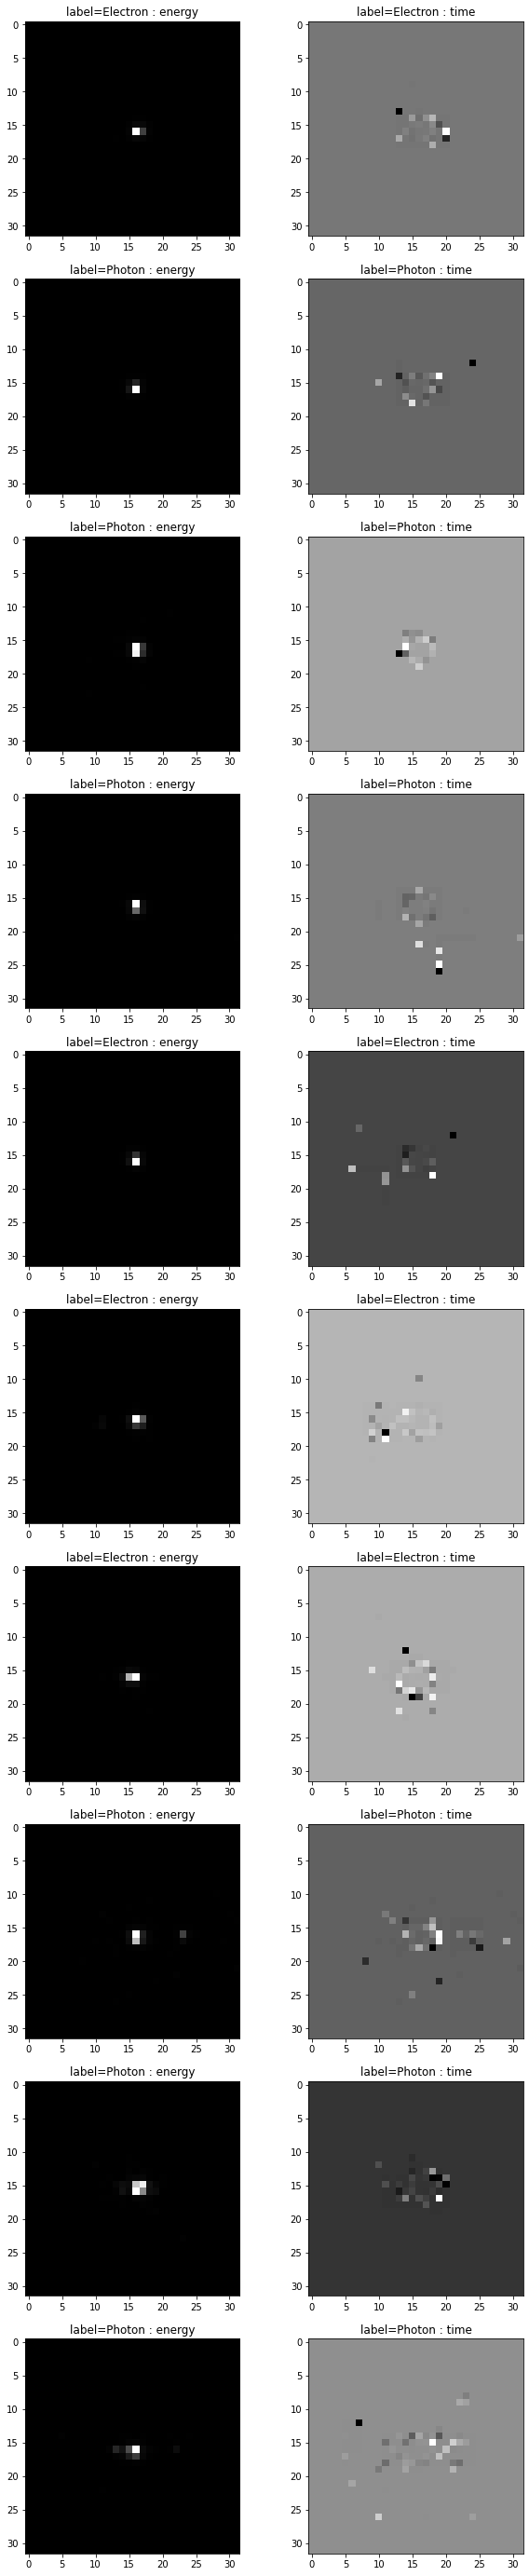

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)
label_val_to_text = {1 : "Electron", 0 : "Photon"}

scale = 5
n = int(batch_size)
to_plot = 10
plt.figure(figsize=(2*scale , scale * to_plot))


for y in range(to_plot):
  plt.subplot(to_plot, 2, 2 * y + 1)
  label = label_val_to_text[train_labels[y].item()]
  plt.title(f"label={label} : energy")
  plt.imshow(train_features[y, 0, :, :], cmap='gray')

  plt.subplot(to_plot, 2, 2 * y + 2)
  plt.title(f"label={label} : time")
  plt.imshow(train_features[y, 1, :, :], cmap='gray')


plt.show()

# Pytorch Util functions 

training function and setting up tensorboard for monitoring

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, saveTo, num_epochs=25):
    writer = SummaryWriter(tensorboard_save_folder)
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], 
                  "epochs" : [], "trainingAUC" : [], "validationAUC" : []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since2 = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y = torch.Tensor()
            pred_y = torch.Tensor()

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                y = torch.cat([y, labels.cpu()])
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred_labels = (outputs >= 0.5).reshape(-1)

                    #print(outputs.shape)
                    loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                    pred_y = torch.cat([pred_y, outputs.cpu()])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred_labels == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

            if phase == "train":
                returnDict["trainingLoss"].append(epoch_loss)
                returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
                returnDict["trainingAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
                writer.add_scalar("Accuracy/train", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/train", AUC_ROC, epoch)
            else:
                returnDict["validationLoss"].append(epoch_loss)
                returnDict["validationAccuracy"].append(epoch_acc.cpu().item())
                returnDict["validationAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/validation", epoch_loss, epoch)
                writer.add_scalar("Accuracy/validation", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/validation", AUC_ROC, epoch)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({ "state_dict" : model.state_dict()}, saveTo)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    returnDict["best_model"] = model
    writer.close()
    return returnDict

Device Used : cuda:0


In [8]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.plot([0, results['epochs'][-1]], [0.8, 0.8], "--", color='black')
    plt.legend()

    plt.show()

In [9]:
def evaluate_model(model, criterion, testing_dataset, testing_dataset_len):
    writer = SummaryWriter(tensorboard_save_folder)
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], 
                  "epochs" : [], "trainingAUC" : [], "validationAUC" : []}
    best_acc = 0.0

    # Each epoch has a training and validation phase
    since2 = time.time()
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()

    # Iterate over data.
    for inputs, labels in testing_dataset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            pred_labels = (outputs >= 0.5).reshape(-1)
            
            #print(outputs.shape)
            loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)

    epoch_loss = running_loss / testing_dataset_len
    epoch_acc = running_corrects.double() / testing_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

    
    time_elapsed = time.time() - since
    print(f'Evaluation completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')



In [10]:
device_used = torch.cuda.get_device_name(device)

print(f"device used is : {device_used}")

device used is : Tesla T4


# Baseline

minimal simple architecture that provide some baseline accuracy

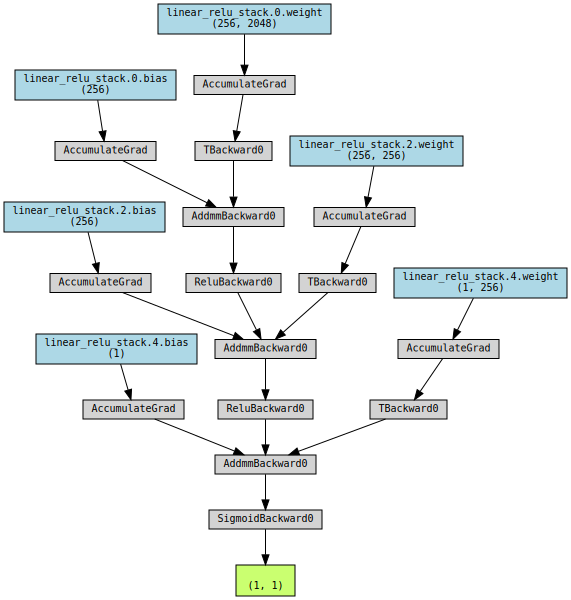

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = BasicNN()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(32,32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 590,593
Trainable params: 590,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "Simple.pt"))

Epoch 0/24
----------
train Loss: 0.6171 Acc: 0.6661 AUC ROC : 0.7167 Time taken : 29.48
val Loss: 0.6002 Acc: 0.6880 AUC ROC : 0.7407 Time taken : 1.95

Epoch 1/24
----------
train Loss: 0.5832 Acc: 0.7009 AUC ROC : 0.7585 Time taken : 25.81
val Loss: 0.5894 Acc: 0.6952 AUC ROC : 0.7558 Time taken : 1.93

Epoch 2/24
----------
train Loss: 0.5662 Acc: 0.7147 AUC ROC : 0.7770 Time taken : 26.09
val Loss: 0.5905 Acc: 0.6981 AUC ROC : 0.7596 Time taken : 1.95

Epoch 3/24
----------
train Loss: 0.5494 Acc: 0.7266 AUC ROC : 0.7936 Time taken : 26.11
val Loss: 0.5909 Acc: 0.7007 AUC ROC : 0.7592 Time taken : 2.06

Epoch 4/24
----------
train Loss: 0.5295 Acc: 0.7390 AUC ROC : 0.8110 Time taken : 25.94
val Loss: 0.6104 Acc: 0.6973 AUC ROC : 0.7523 Time taken : 1.96

Epoch 5/24
----------
train Loss: 0.5089 Acc: 0.7521 AUC ROC : 0.8276 Time taken : 25.92
val Loss: 0.6251 Acc: 0.6932 AUC ROC : 0.7434 Time taken : 1.93

Epoch 6/24
----------
train Loss: 0.4900 Acc: 0.7632 AUC ROC : 0.8415 Time t

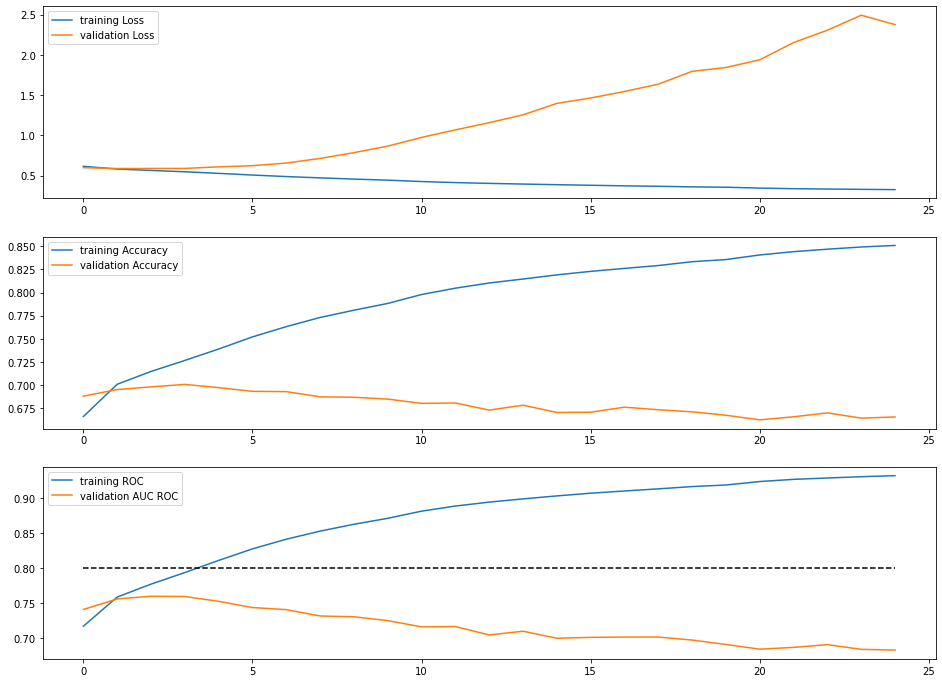

In [ ]:
plotResults(simple_res)

## Analysis
MLP overfits significantly (only in few first epochs we see some improvement for validation dataset, after that significant decay in performance)

# Basic CNN

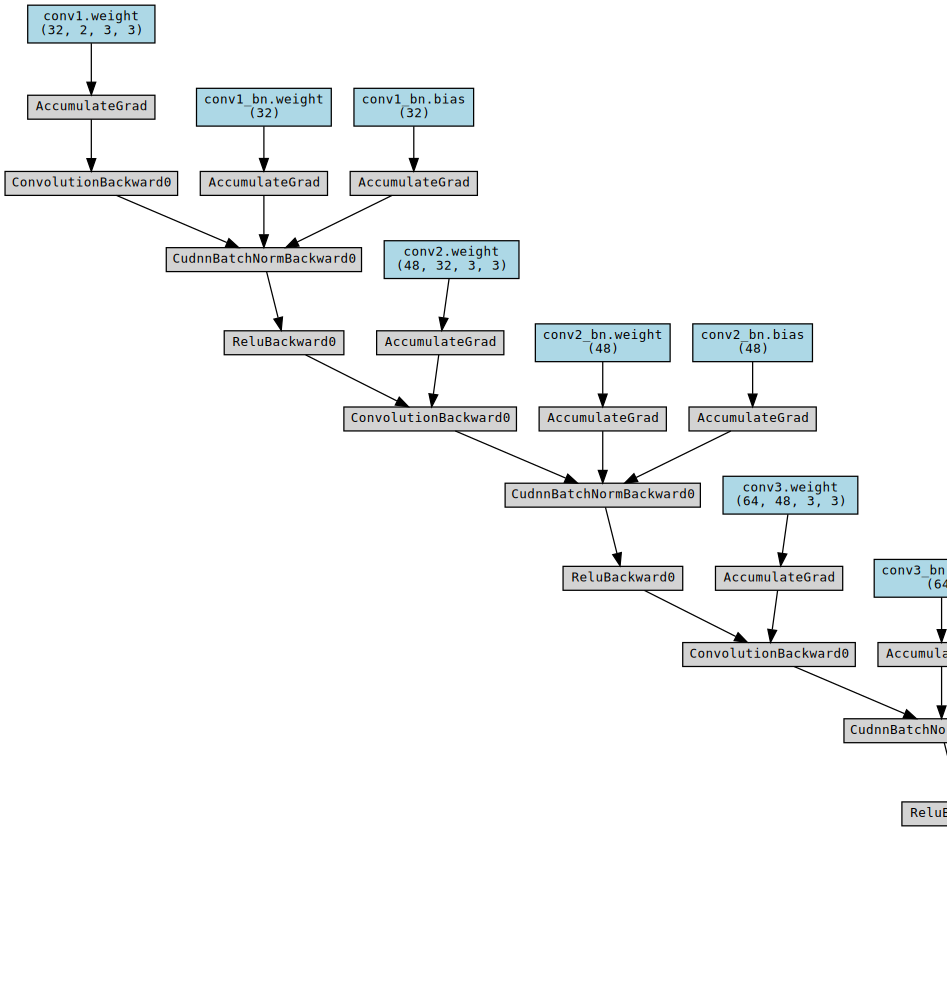

In [ ]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(80)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(11520, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.max_pool(conv4)
        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 80, 24, 24]          46,080
       BatchNorm2d-8           [-1, 80, 24, 24]             160
         MaxPool2d-9           [-1, 80, 12, 12]               0
           Linear-10                    [-1, 1]          11,520
          Sigmoid-11                    [-1, 1]               0
Total params: 100,096
Trainable params: 100,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN.pth"))

Epoch 0/24
----------
train Loss: 0.6102 Acc: 0.6756 AUC ROC : 0.7295 Time taken : 78.31
val Loss: 0.5894 Acc: 0.6984 AUC ROC : 0.7633 Time taken : 3.78

Epoch 1/24
----------
train Loss: 0.5739 Acc: 0.7093 AUC ROC : 0.7695 Time taken : 77.13
val Loss: 0.5781 Acc: 0.7066 AUC ROC : 0.7803 Time taken : 3.8

Epoch 2/24
----------
train Loss: 0.5642 Acc: 0.7163 AUC ROC : 0.7796 Time taken : 77.19
val Loss: 0.5581 Acc: 0.7209 AUC ROC : 0.7851 Time taken : 3.81

Epoch 3/24
----------
train Loss: 0.5581 Acc: 0.7211 AUC ROC : 0.7858 Time taken : 77.0
val Loss: 0.5557 Acc: 0.7201 AUC ROC : 0.7887 Time taken : 3.8

Epoch 4/24
----------
train Loss: 0.5544 Acc: 0.7238 AUC ROC : 0.7893 Time taken : 77.11
val Loss: 0.5557 Acc: 0.7219 AUC ROC : 0.7919 Time taken : 3.88

Epoch 5/24
----------
train Loss: 0.5511 Acc: 0.7259 AUC ROC : 0.7924 Time taken : 77.07
val Loss: 0.5503 Acc: 0.7244 AUC ROC : 0.7927 Time taken : 3.81

Epoch 6/24
----------
train Loss: 0.5485 Acc: 0.7282 AUC ROC : 0.7949 Time take

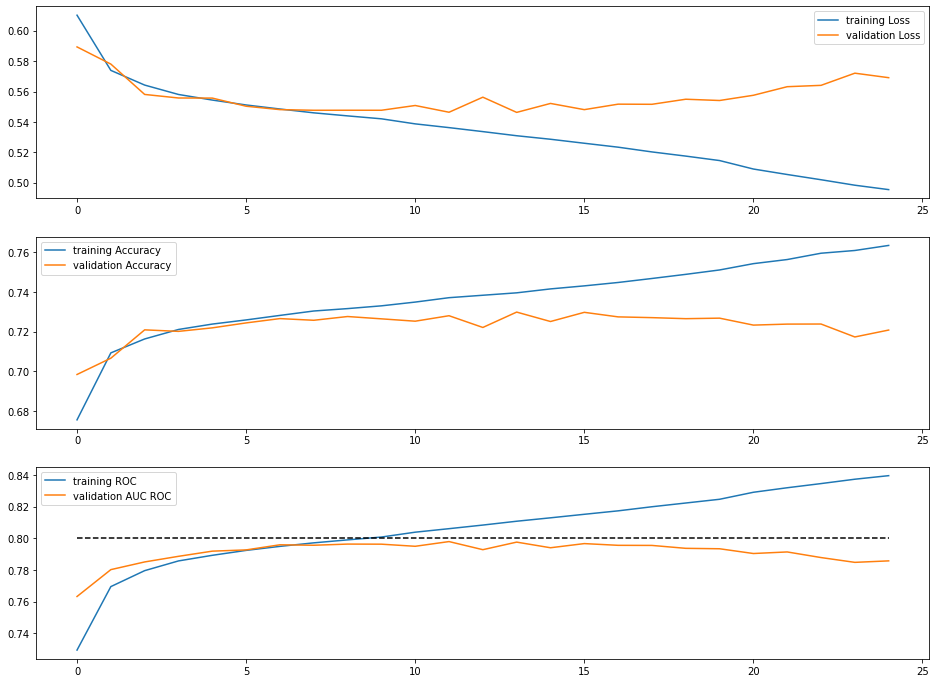

In [ ]:
plotResults(simple_res)

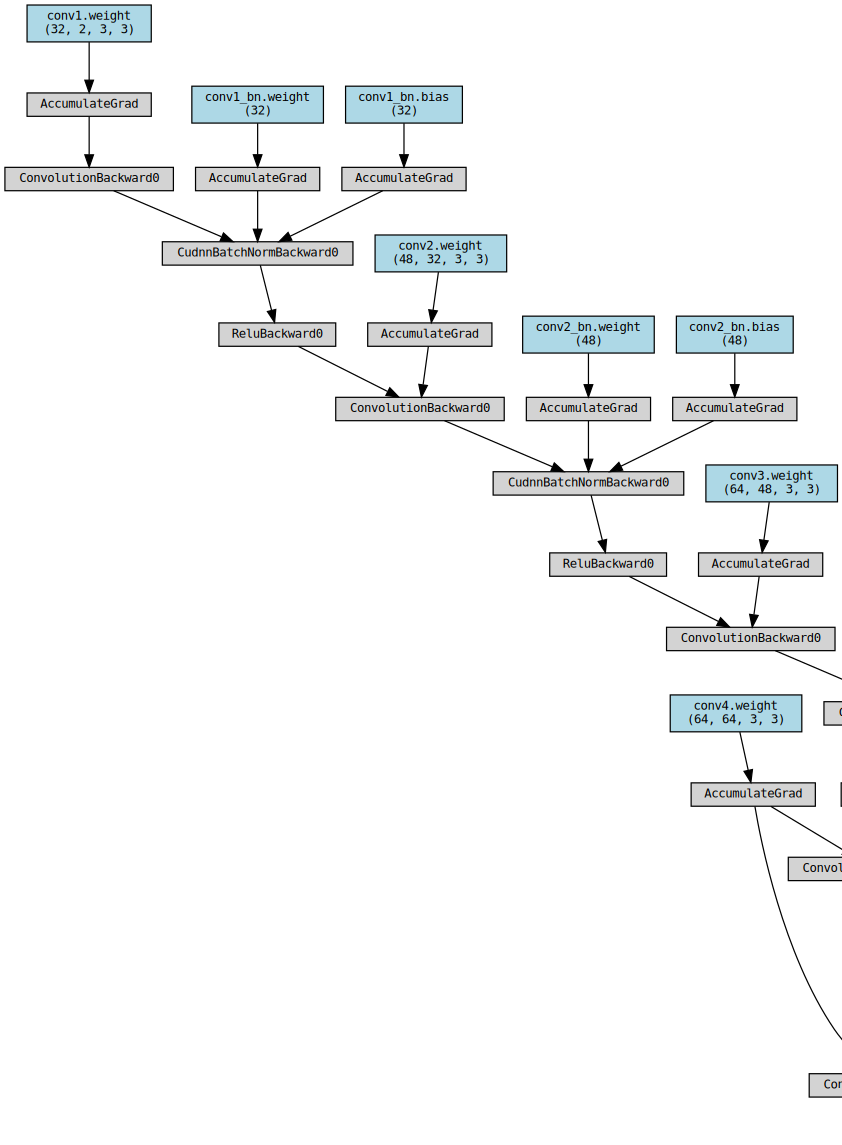

In [ ]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7744, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv4(conv4)))
        max_pool = self.max_pool(conv5)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 64, 24, 24]          36,864
       BatchNorm2d-8           [-1, 64, 24, 24]             128
            Conv2d-9           [-1, 64, 22, 22]          36,864
      BatchNorm2d-10           [-1, 64, 22, 22]             128
        MaxPool2d-11           [-1, 64, 11, 11]               0
           Linear-12                    [-1, 1]           7,744
          Sigmoid-13                    [-1, 1]               0
Total params: 124,064
Trainable params:

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN2.pth"))

Epoch 0/24
----------
train Loss: 0.6114 Acc: 0.6739 AUC ROC : 0.7273 Time taken : 84.98
val Loss: 0.5790 Acc: 0.7035 AUC ROC : 0.7657 Time taken : 4.19

Epoch 1/24
----------
train Loss: 0.5755 Acc: 0.7085 AUC ROC : 0.7678 Time taken : 84.9
val Loss: 0.5700 Acc: 0.7115 AUC ROC : 0.7745 Time taken : 4.24

Epoch 2/24
----------
train Loss: 0.5635 Acc: 0.7171 AUC ROC : 0.7802 Time taken : 85.19
val Loss: 0.5659 Acc: 0.7144 AUC ROC : 0.7860 Time taken : 4.22

Epoch 3/24
----------
train Loss: 0.5571 Acc: 0.7221 AUC ROC : 0.7866 Time taken : 84.89
val Loss: 0.5517 Acc: 0.7223 AUC ROC : 0.7929 Time taken : 4.2

Epoch 4/24
----------
train Loss: 0.5527 Acc: 0.7253 AUC ROC : 0.7908 Time taken : 84.95
val Loss: 0.5500 Acc: 0.7257 AUC ROC : 0.7946 Time taken : 4.17

Epoch 5/24
----------
train Loss: 0.5494 Acc: 0.7275 AUC ROC : 0.7938 Time taken : 84.93
val Loss: 0.5461 Acc: 0.7303 AUC ROC : 0.7991 Time taken : 4.23

Epoch 6/24
----------
train Loss: 0.5462 Acc: 0.7300 AUC ROC : 0.7969 Time tak

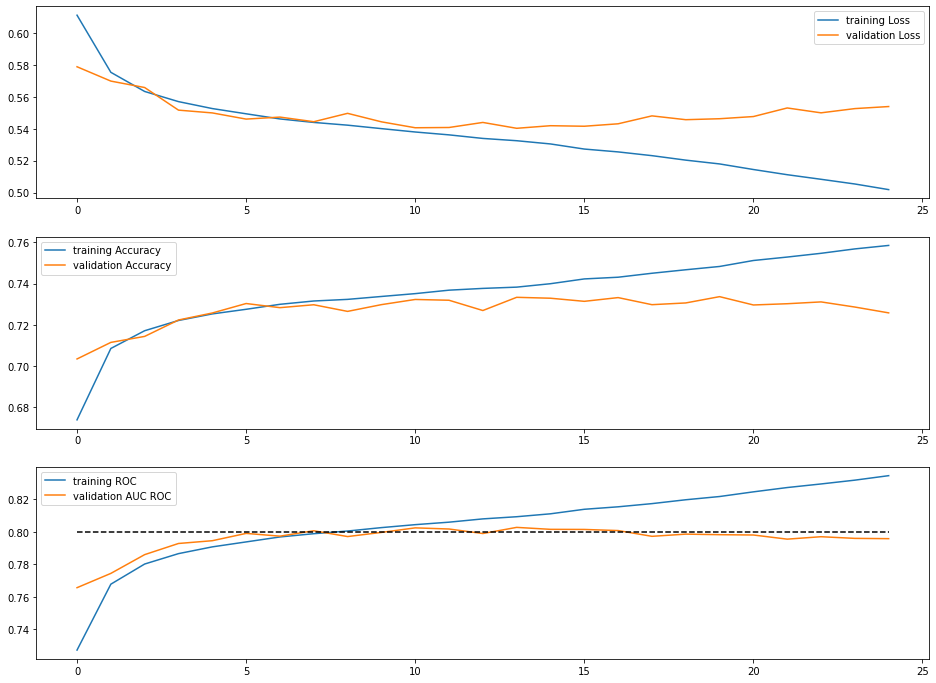

In [ ]:
plotResults(simple_res)

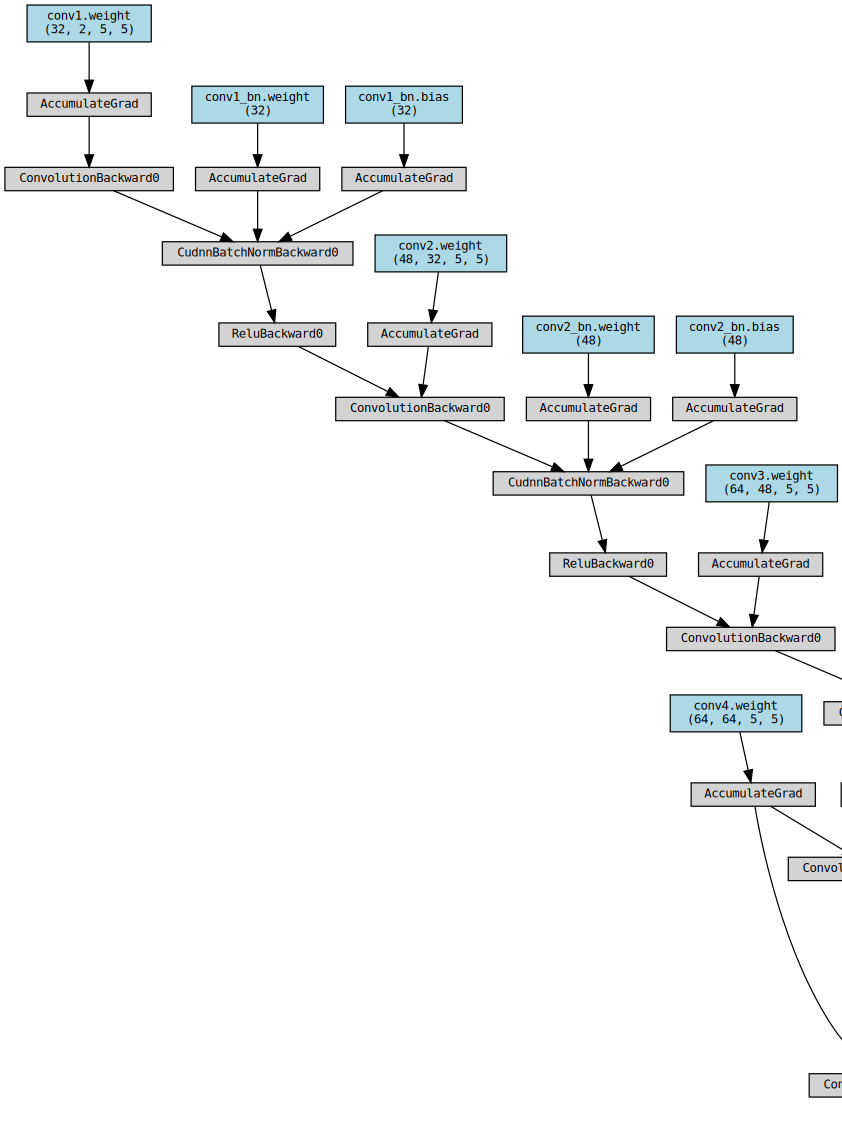

In [ ]:
class ModelM5(nn.Module):
    def __init__(self):
        super(ModelM5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 5, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2304, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv4(conv4)))
        max_pool = self.max_pool(conv5)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM5()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,600
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 48, 24, 24]          38,400
       BatchNorm2d-4           [-1, 48, 24, 24]              96
            Conv2d-5           [-1, 64, 20, 20]          76,800
       BatchNorm2d-6           [-1, 64, 20, 20]             128
            Conv2d-7           [-1, 64, 16, 16]         102,400
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 12, 12]         102,400
      BatchNorm2d-10           [-1, 64, 12, 12]             128
        MaxPool2d-11             [-1, 64, 6, 6]               0
           Linear-12                    [-1, 1]           2,304
          Sigmoid-13                    [-1, 1]               0
Total params: 324,448
Trainable params:

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6058 Acc: 0.6770 AUC ROC : 0.7322 Time taken : 67.97
val Loss: 0.5733 Acc: 0.7089 AUC ROC : 0.7736 Time taken : 3.67

Epoch 1/24
----------
train Loss: 0.5667 Acc: 0.7148 AUC ROC : 0.7765 Time taken : 67.82
val Loss: 0.5619 Acc: 0.7188 AUC ROC : 0.7843 Time taken : 3.7

Epoch 2/24
----------
train Loss: 0.5577 Acc: 0.7214 AUC ROC : 0.7857 Time taken : 68.12
val Loss: 0.5542 Acc: 0.7235 AUC ROC : 0.7903 Time taken : 3.64

Epoch 3/24
----------
train Loss: 0.5522 Acc: 0.7250 AUC ROC : 0.7911 Time taken : 68.5
val Loss: 0.5638 Acc: 0.7179 AUC ROC : 0.7874 Time taken : 3.71

Epoch 4/24
----------
train Loss: 0.5493 Acc: 0.7274 AUC ROC : 0.7939 Time taken : 67.91
val Loss: 0.5553 Acc: 0.7211 AUC ROC : 0.7925 Time taken : 3.91

Epoch 5/24
----------
train Loss: 0.5459 Acc: 0.7293 AUC ROC : 0.7970 Time taken : 67.84
val Loss: 0.5531 Acc: 0.7240 AUC ROC : 0.7925 Time taken : 3.64

Epoch 6/24
----------
train Loss: 0.5434 Acc: 0.7313 AUC ROC : 0.7994 Time tak

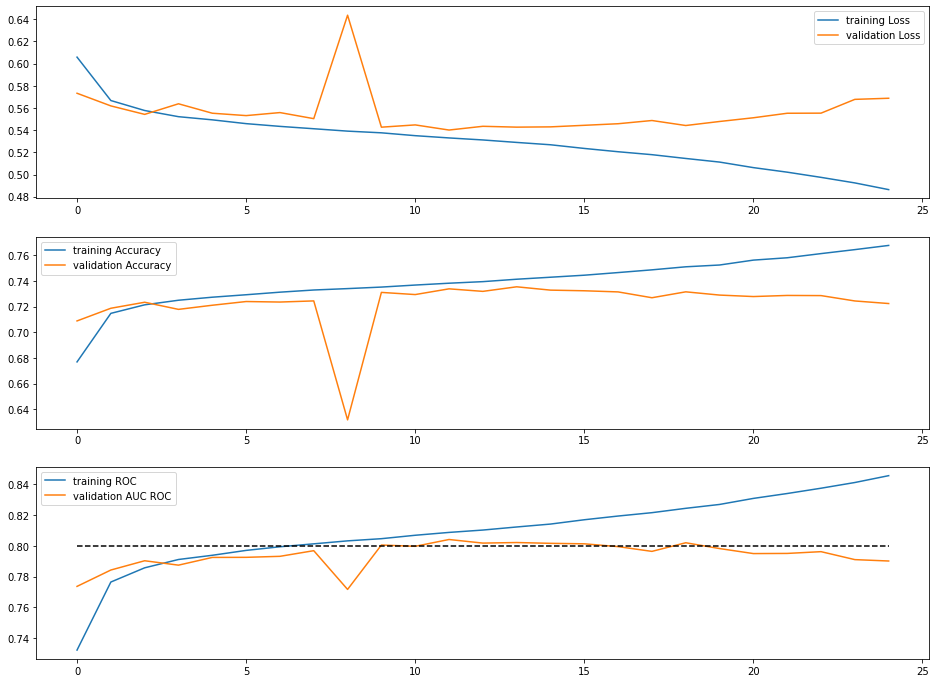

In [ ]:
plotResults(simple_res)

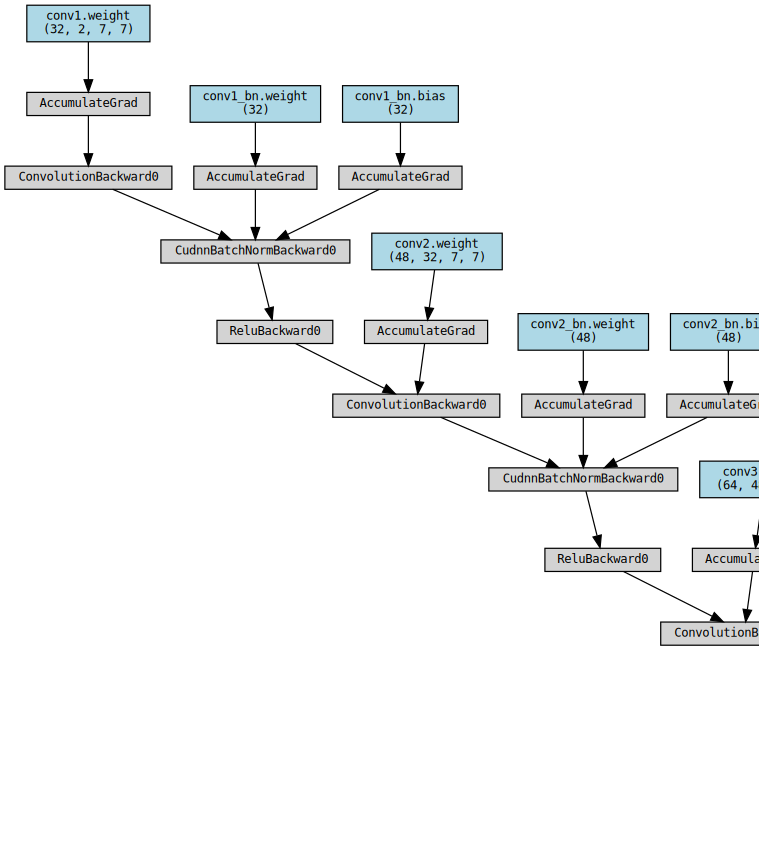

In [ ]:
class ModelM7(nn.Module):
    def __init__(self):
        super(ModelM7, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 7, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 7, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 7, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        max_pool = self.max_pool(conv3)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM7()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           3,136
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 48, 20, 20]          75,264
       BatchNorm2d-4           [-1, 48, 20, 20]              96
            Conv2d-5           [-1, 64, 14, 14]         150,528
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Linear-8                    [-1, 1]           3,136
           Sigmoid-9                    [-1, 1]               0
Total params: 232,352
Trainable params: 232,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.89
Estimated Total Size (MB): 1.73
-------------------------------------------

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6042 Acc: 0.6782 AUC ROC : 0.7349 Time taken : 45.01
val Loss: 0.5919 Acc: 0.6993 AUC ROC : 0.7661 Time taken : 2.82

Epoch 1/24
----------
train Loss: 0.5667 Acc: 0.7152 AUC ROC : 0.7768 Time taken : 44.95
val Loss: 0.5595 Acc: 0.7186 AUC ROC : 0.7901 Time taken : 2.82

Epoch 2/24
----------
train Loss: 0.5576 Acc: 0.7215 AUC ROC : 0.7858 Time taken : 44.97
val Loss: 0.5547 Acc: 0.7217 AUC ROC : 0.7919 Time taken : 2.84

Epoch 3/24
----------
train Loss: 0.5522 Acc: 0.7249 AUC ROC : 0.7912 Time taken : 45.0
val Loss: 0.5501 Acc: 0.7263 AUC ROC : 0.7935 Time taken : 2.86

Epoch 4/24
----------
train Loss: 0.5478 Acc: 0.7284 AUC ROC : 0.7954 Time taken : 44.87
val Loss: 0.5487 Acc: 0.7268 AUC ROC : 0.7946 Time taken : 3.08

Epoch 5/24
----------
train Loss: 0.5430 Acc: 0.7320 AUC ROC : 0.7999 Time taken : 44.77
val Loss: 0.5483 Acc: 0.7273 AUC ROC : 0.7958 Time taken : 2.86

Epoch 6/24
----------
train Loss: 0.5394 Acc: 0.7340 AUC ROC : 0.8031 Time ta

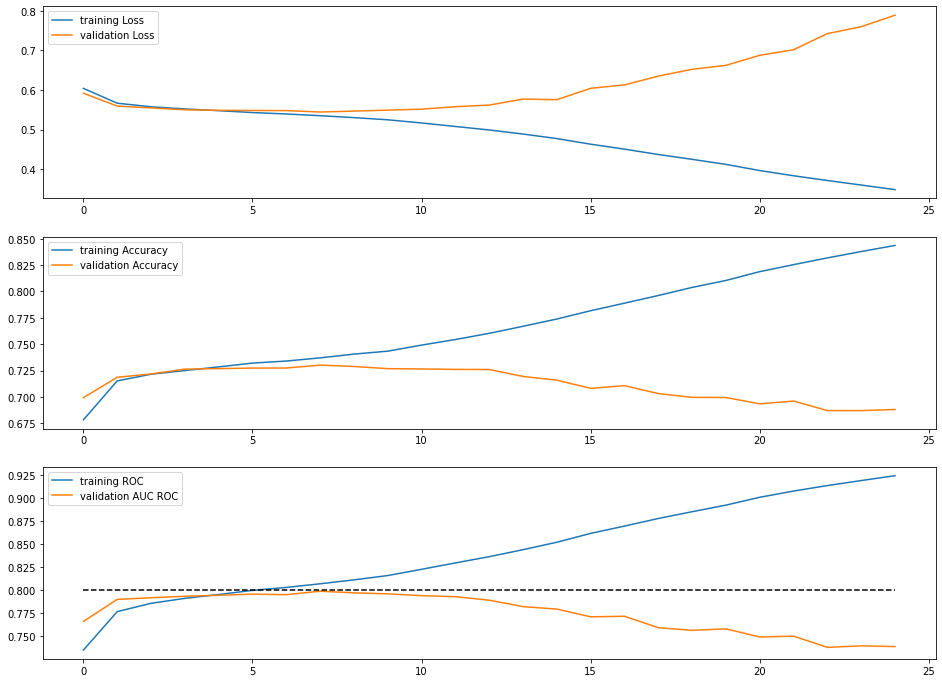

In [ ]:
plotResults(simple_res)

# Even smaller

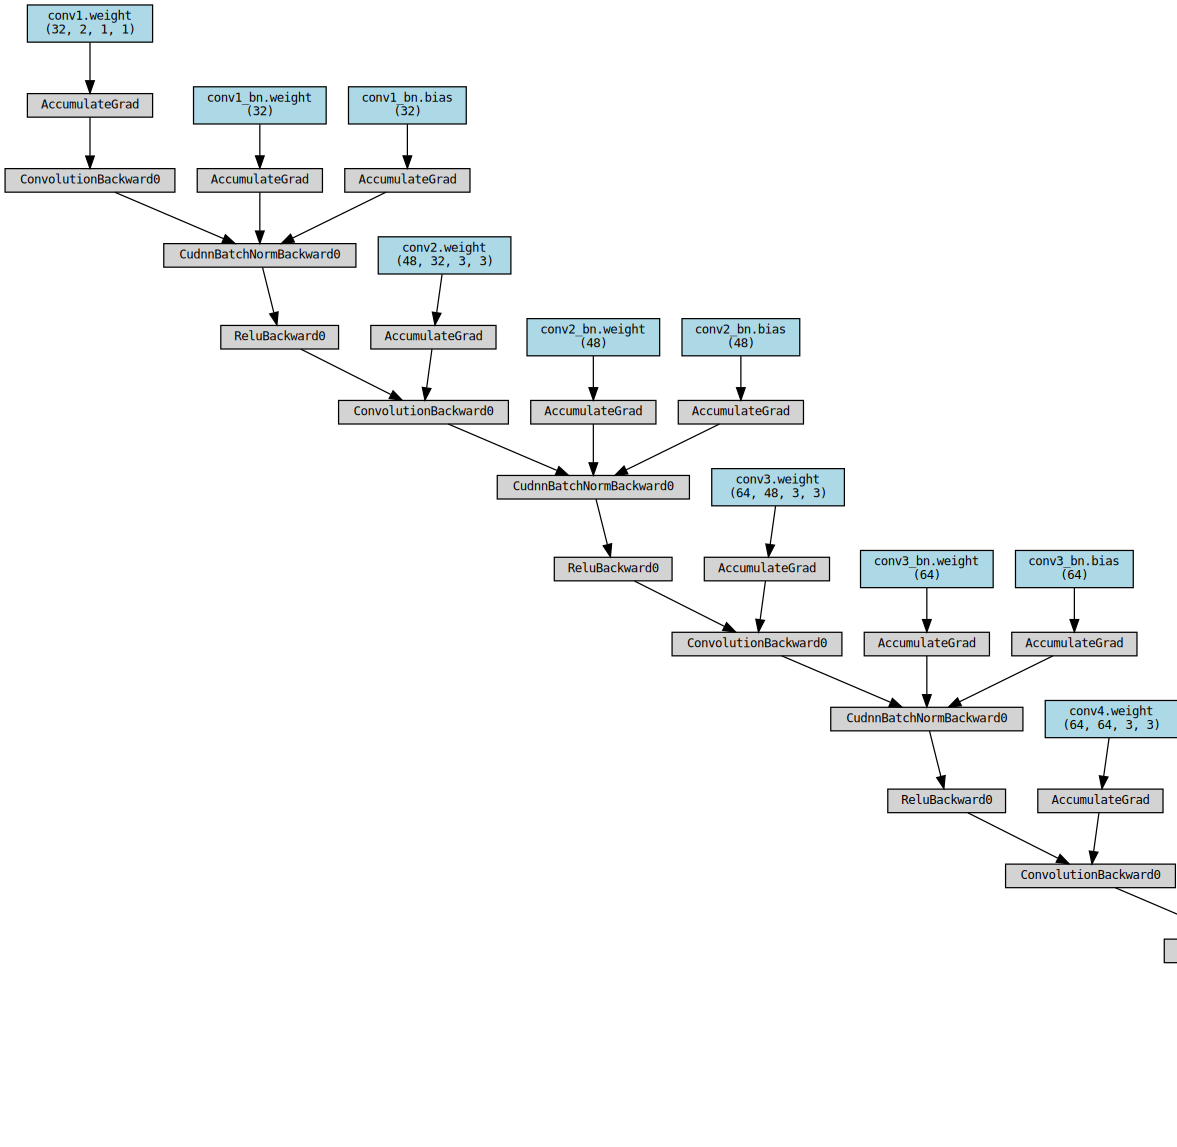

In [ ]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 18x18
        self.conv6_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7744, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv4)))
        
        max_pool = self.max_pool(conv6)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 48, 30, 30]          13,824
       BatchNorm2d-4           [-1, 48, 30, 30]              96
            Conv2d-5           [-1, 64, 28, 28]          27,648
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7           [-1, 64, 26, 26]          36,864
       BatchNorm2d-8           [-1, 64, 26, 26]             128
            Conv2d-9           [-1, 64, 24, 24]          36,864
      BatchNorm2d-10           [-1, 64, 24, 24]             128
           Conv2d-11           [-1, 64, 22, 22]         102,400
      BatchNorm2d-12           [-1, 64, 22, 22]             128
        MaxPool2d-13           [-1, 64, 11, 11]               0
           Linear-14                   

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6079 Acc: 0.6771 AUC ROC : 0.7312 Time taken : 104.78
val Loss: 1.4372 Acc: 0.5000 AUC ROC : 0.7495 Time taken : 5.08

Epoch 1/24
----------
train Loss: 0.5687 Acc: 0.7138 AUC ROC : 0.7750 Time taken : 101.31
val Loss: 0.6346 Acc: 0.6759 AUC ROC : 0.7687 Time taken : 5.13

Epoch 2/24
----------
train Loss: 0.5588 Acc: 0.7202 AUC ROC : 0.7850 Time taken : 101.66
val Loss: 0.5493 Acc: 0.7257 AUC ROC : 0.7942 Time taken : 5.31

Epoch 3/24
----------
train Loss: 0.5533 Acc: 0.7250 AUC ROC : 0.7903 Time taken : 101.28
val Loss: 0.5494 Acc: 0.7266 AUC ROC : 0.7962 Time taken : 5.19

Epoch 4/24
----------
train Loss: 0.5498 Acc: 0.7274 AUC ROC : 0.7936 Time taken : 101.87
val Loss: 0.5466 Acc: 0.7301 AUC ROC : 0.7966 Time taken : 5.17

Epoch 5/24
----------
train Loss: 0.5469 Acc: 0.7293 AUC ROC : 0.7964 Time taken : 101.05
val Loss: 0.5500 Acc: 0.7272 AUC ROC : 0.7982 Time taken : 5.15

Epoch 6/24
----------
train Loss: 0.5439 Acc: 0.7316 AUC ROC : 0.7991 

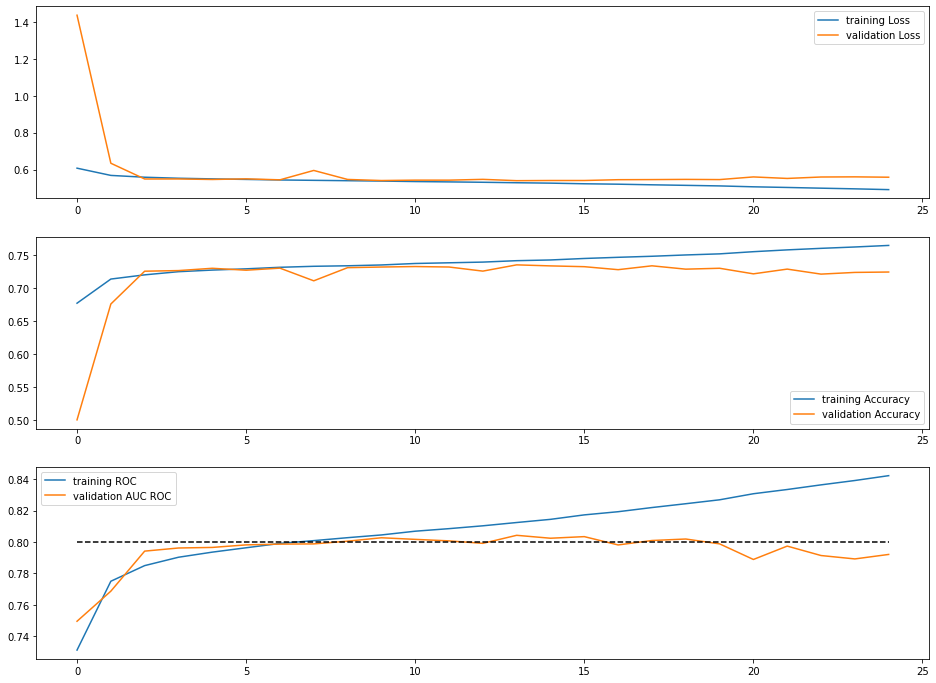

In [ ]:
plotResults(simple_res)

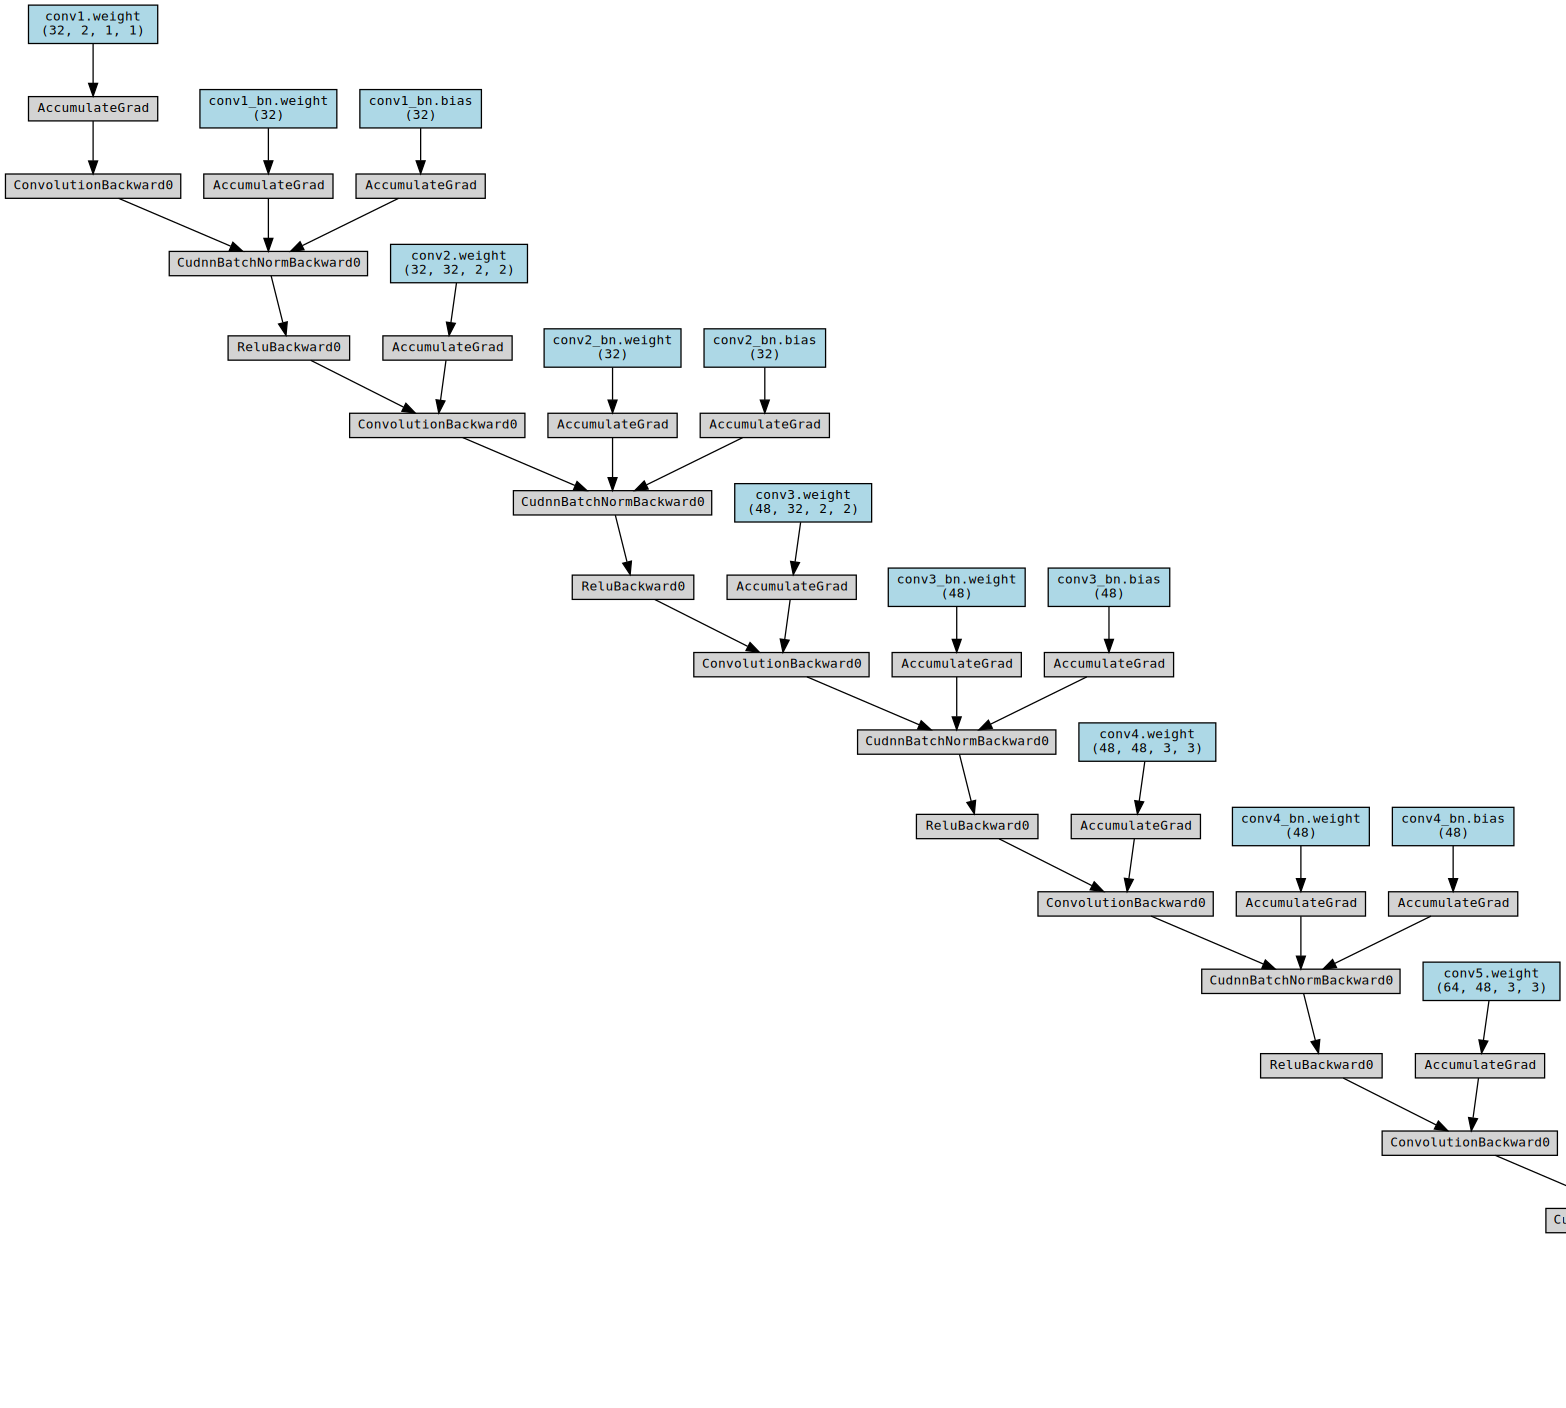

In [ ]:
class ModelV4(nn.Module):
    def __init__(self):
        super(ModelV4, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5184, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))

        max_pool = self.max_pool(conv7)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelV4()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 31, 31]           4,096
       BatchNorm2d-4           [-1, 32, 31, 31]              64
            Conv2d-5           [-1, 48, 30, 30]           6,144
       BatchNorm2d-6           [-1, 48, 30, 30]              96
            Conv2d-7           [-1, 48, 28, 28]          20,736
       BatchNorm2d-8           [-1, 48, 28, 28]              96
            Conv2d-9           [-1, 64, 26, 26]          27,648
      BatchNorm2d-10           [-1, 64, 26, 26]             128
           Conv2d-11           [-1, 64, 22, 22]         102,400
      BatchNorm2d-12           [-1, 64, 22, 22]             128
           Conv2d-13           [-1, 64, 18, 18]         102,400
      BatchNorm2d-14           [-1, 64,

Epoch 0/24
----------
train Loss: 0.6060 Acc: 0.6776 AUC ROC : 0.7327 Time taken : 108.67
val Loss: 0.5798 Acc: 0.7019 AUC ROC : 0.7708 Time taken : 4.88

Epoch 1/24
----------
train Loss: 0.5688 Acc: 0.7138 AUC ROC : 0.7748 Time taken : 107.34
val Loss: 0.5633 Acc: 0.7186 AUC ROC : 0.7854 Time taken : 4.87

Epoch 2/24
----------
train Loss: 0.5578 Acc: 0.7215 AUC ROC : 0.7859 Time taken : 107.4
val Loss: 0.5514 Acc: 0.7248 AUC ROC : 0.7932 Time taken : 4.84

Epoch 3/24
----------
train Loss: 0.5521 Acc: 0.7258 AUC ROC : 0.7915 Time taken : 107.54
val Loss: 0.5667 Acc: 0.7216 AUC ROC : 0.7907 Time taken : 4.87

Epoch 4/24
----------
train Loss: 0.5476 Acc: 0.7288 AUC ROC : 0.7956 Time taken : 107.17
val Loss: 0.5657 Acc: 0.7176 AUC ROC : 0.7948 Time taken : 4.89

Epoch 5/24
----------
train Loss: 0.5444 Acc: 0.7312 AUC ROC : 0.7987 Time taken : 108.1
val Loss: 0.6367 Acc: 0.6116 AUC ROC : 0.7486 Time taken : 4.86

Epoch 6/24
----------
train Loss: 0.5422 Acc: 0.7328 AUC ROC : 0.8007 Ti

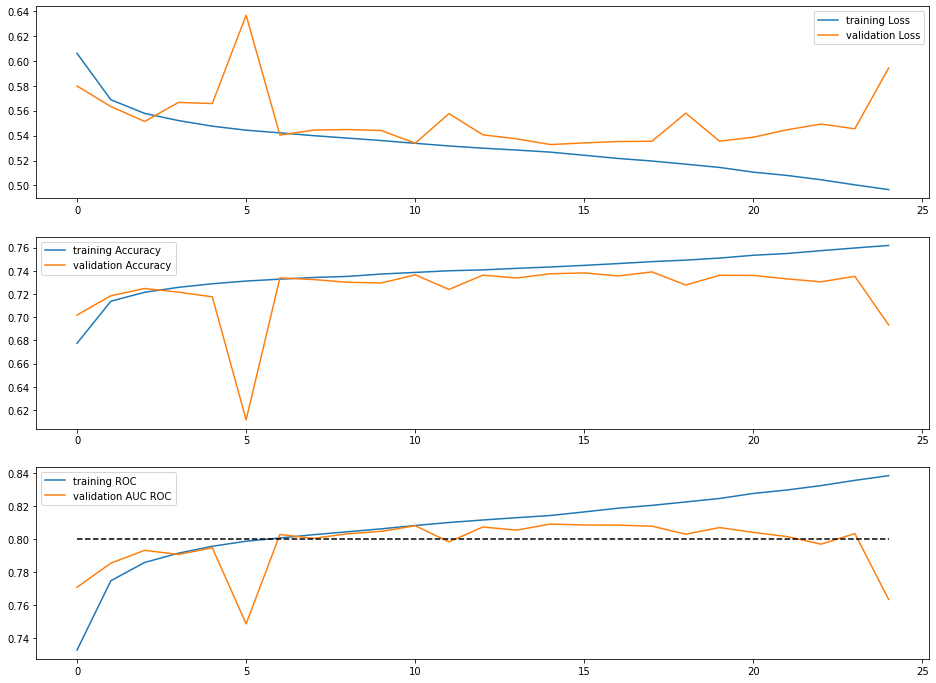

In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

Epoch 0/24
----------
train Loss: 0.6109 Acc: 0.6744 AUC ROC : 0.7271 Time taken : 108.69
val Loss: 0.5904 Acc: 0.6926 AUC ROC : 0.7632 Time taken : 5.05

Epoch 1/24
----------
train Loss: 0.5703 Acc: 0.7127 AUC ROC : 0.7733 Time taken : 108.44
val Loss: 0.5642 Acc: 0.7178 AUC ROC : 0.7837 Time taken : 4.98

Epoch 2/24
----------
train Loss: 0.5594 Acc: 0.7209 AUC ROC : 0.7843 Time taken : 108.29
val Loss: 0.6177 Acc: 0.6566 AUC ROC : 0.7538 Time taken : 4.89

Epoch 3/24
----------
train Loss: 0.5534 Acc: 0.7253 AUC ROC : 0.7900 Time taken : 108.1
val Loss: 0.5570 Acc: 0.7212 AUC ROC : 0.7902 Time taken : 4.96

Epoch 4/24
----------
train Loss: 0.5498 Acc: 0.7274 AUC ROC : 0.7934 Time taken : 108.38
val Loss: 0.5527 Acc: 0.7248 AUC ROC : 0.7935 Time taken : 4.88

Epoch 5/24
----------
train Loss: 0.5462 Acc: 0.7293 AUC ROC : 0.7968 Time taken : 108.28
val Loss: 0.5584 Acc: 0.7188 AUC ROC : 0.7985 Time taken : 4.86

Epoch 6/24
----------
train Loss: 0.5433 Acc: 0.7317 AUC ROC : 0.7995 T

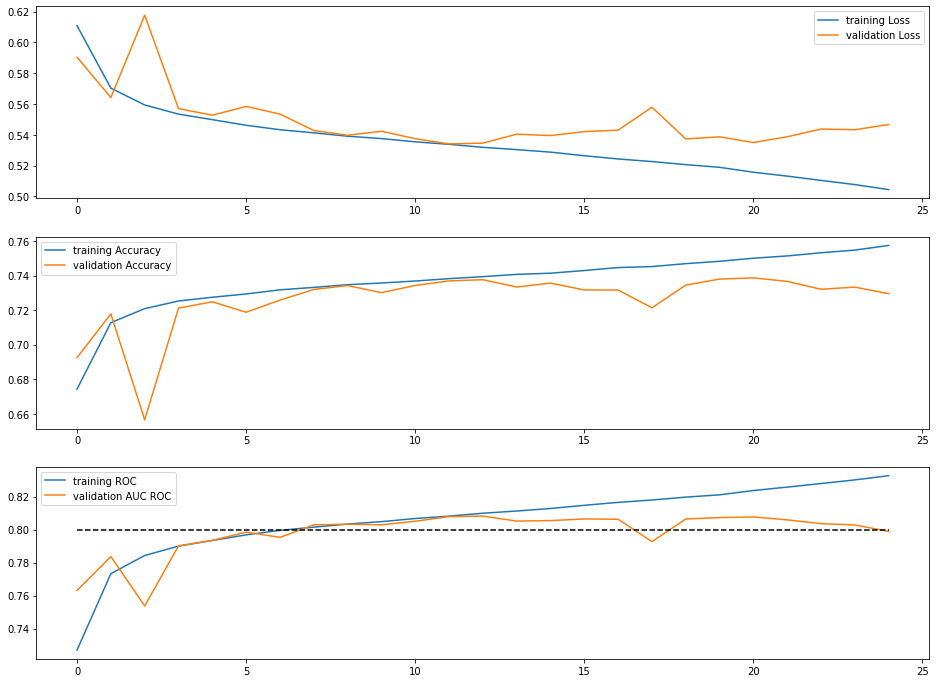

In [ ]:
model_ft = ModelV4()
model_ft = model_ft.to(device)

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

## Maxouts

Change from Relu to something eles

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
           Conv2d-10           [-1, 48, 28, 28]          20,736
      BatchNorm2d-11           [-1, 48, 28, 28]              96
             ReLU-12           [-1, 48, 28, 28]               0
           Conv2d-13           [-1, 64, 26, 26]          27,648
      BatchNorm2d-14           [-1, 64,

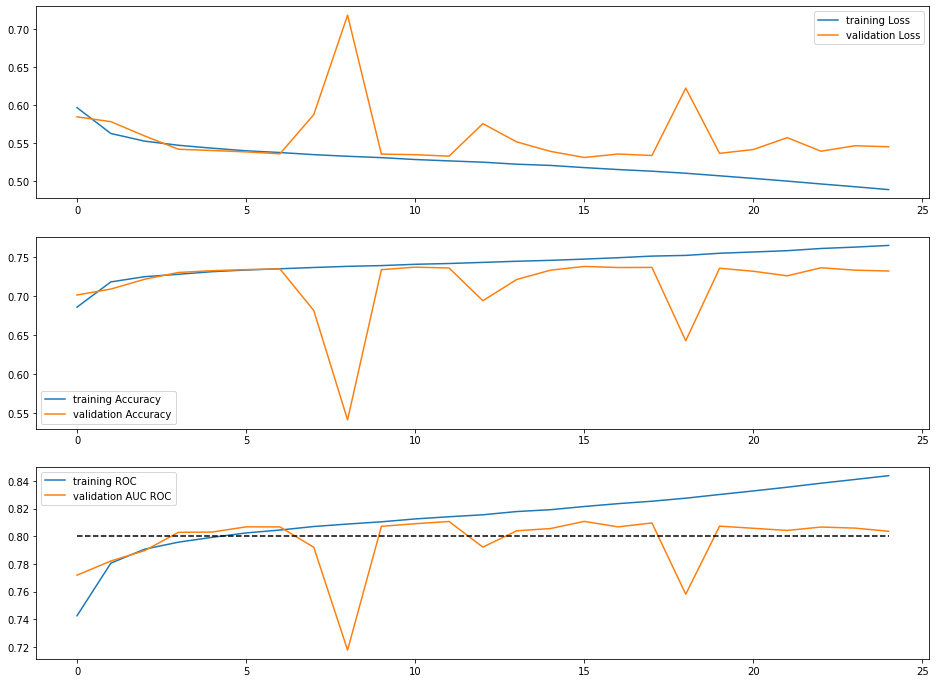

In [ ]:
class ModelV5(nn.Module):
    def __init__(self):
        super(ModelV5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)

        self.conv6 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activation6 = nn.ReLU()

        self.conv7 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activation7 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(1024, 64, bias=False)
        self.activation8 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv5 = self.max_pool1(conv5)
        conv6 = self.activation6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activation7(self.conv7_bn(self.conv7(conv6)))
        conv7 = self.max_pool2(conv7)

        flat1 = torch.flatten(conv7.permute(0, 2, 3, 1), 1)
        ret = self.activation8(self.fc1(flat1))
        logits = self.fc2(ret)
        return self.sigmoid(logits)

model_ft = ModelV5()
model_ft = model_ft.to(device)
print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
           Conv2d-10           [-1, 48, 28, 28]          20,736
      BatchNorm2d-11           [-1, 48, 28, 28]              96
             ReLU-12           [-1, 48, 28, 28]               0
           Conv2d-13           [-1, 64, 24, 24]          76,800
      BatchNorm2d-14           [-1, 64,

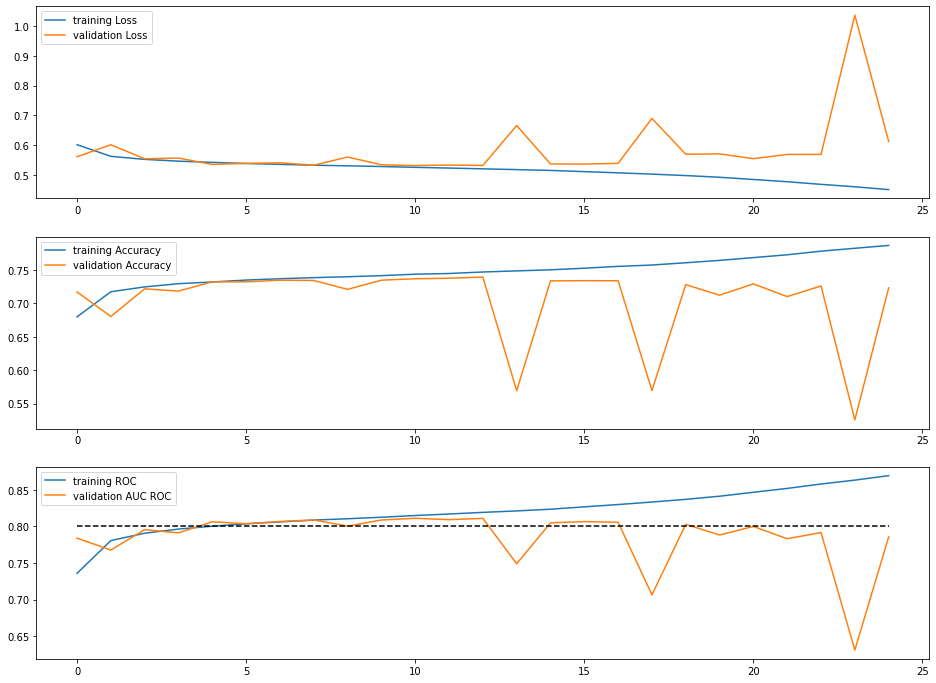

In [ ]:
class ModelV6(nn.Module):
    def __init__(self):
        super(ModelV6, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()

        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv6_bn = nn.BatchNorm2d(64)
        self.activation6 = nn.ReLU()

        self.conv7 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv7_bn = nn.BatchNorm2d(64)
        self.activation7 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(4096, 64, bias=False)
        self.activation8 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv6 = self.activation6(self.conv6_bn(self.conv6(conv5)))
        conv7 = self.activation7(self.conv7_bn(self.conv7(conv6)))
        conv7 = self.max_pool2(conv7)

        flat1 = torch.flatten(conv7.permute(0, 2, 3, 1), 1)
        ret = self.activation8(self.fc1(flat1))
        logits = self.fc2(ret)
        return self.sigmoid(logits)

model_ft = ModelV6()
model_ft = model_ft.to(device)
print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

# Splitted channels

motivated by the fact that the two channels represent different values (in terms of units). Split the channels, make some convolutions and after that combine and output the label


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              32
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 32, 30, 30]           4,096
       BatchNorm2d-8           [-1, 32, 30, 30]              64
              ReLU-9           [-1, 32, 30, 30]               0
           Conv2d-10           [-1, 32, 28, 28]           9,216
      BatchNorm2d-11           [-1, 32, 28, 28]              64
             ReLU-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 26, 26]           9,216
      BatchNorm2d-14           [-1, 32,

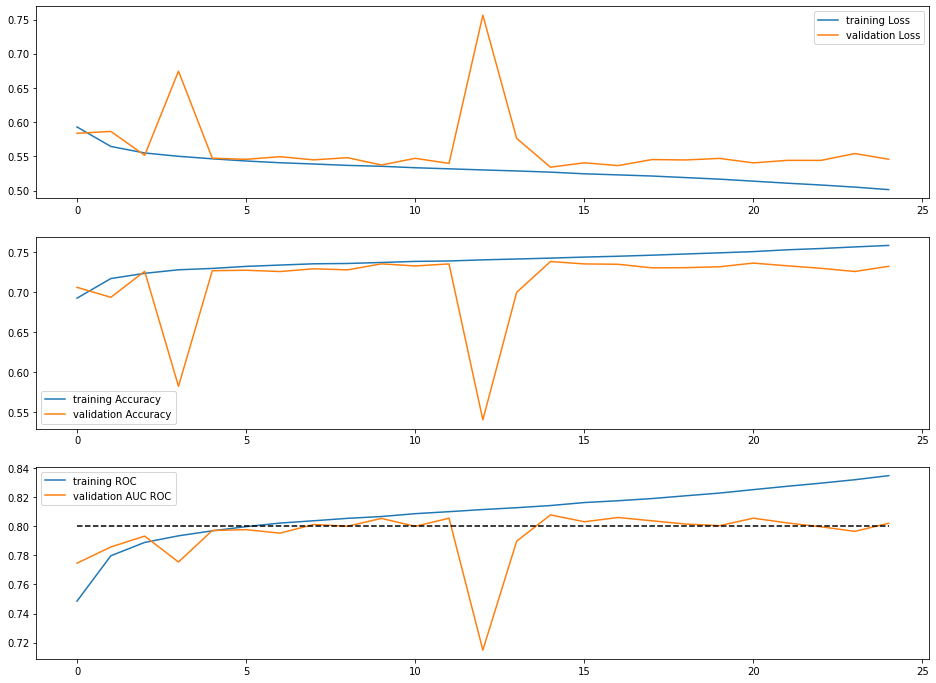

In [ ]:
class modelSingleChannel(nn.Module):
    def __init__(self):
        super(modelSingleChannel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(32)
        self.activation3 = nn.ReLU()

        self.conv4 = nn.Conv2d(32, 32, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(32)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(32, 32, 3, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(32)
        self.activation5 = nn.ReLU()

    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        return conv5

class splittedModel(nn.Module):
  def __init__(self):
    super(splittedModel, self).__init__()
    self.time_channels = modelSingleChannel()
    self.energy_channels = modelSingleChannel()

    self.conv1 = nn.Conv2d(64, 64, 3, bias=False)
    self.conv1_bn = nn.BatchNorm2d(64)
    self.activation1 = nn.ReLU()

    self.conv2 = nn.Conv2d(64, 64, 5, bias=False)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.activation2 = nn.ReLU()

    self.conv3 = nn.Conv2d(64, 64, 5, bias=False)
    self.conv3_bn = nn.BatchNorm2d(64)
    self.activation3 = nn.ReLU()

    self.max_pool = nn.MaxPool2d(2)
    self.linear = nn.Linear(4096, 1)
    self.final_activation = nn.Sigmoid()

  def forward(self, x):
    energy, time = x[:, 0, :, :].reshape(-1, 1, 32, 32), x[:, 1, :, :].reshape(-1, 1, 32, 32)
    time_fwd, energy_fwd = self.energy_channels(energy), self.time_channels(time)
    
    combined = torch.cat([time_fwd, energy_fwd], dim=1)
    conv1 = self.activation1(self.conv1_bn(self.conv1(combined)))
    conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
    conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))

    conv3 = self.max_pool(conv3)

    flattened = torch.flatten(conv3.permute(0, 2, 3, 1), 1)

    return self.final_activation(self.linear(flattened))


model_ft = splittedModel()
model_ft = model_ft.to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 5e-4)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

# Commonly used layers in CV 
## ConvNeXT

paper and credit https://github.com/facebookresearch/ConvNeXt 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             608
         LayerNorm-2           [-1, 32, 15, 15]              64
            Conv2d-3           [-1, 32, 15, 15]             320
         LayerNorm-4           [-1, 15, 15, 32]              64
            Linear-5          [-1, 15, 15, 128]           4,224
              GELU-6          [-1, 15, 15, 128]               0
            Linear-7           [-1, 15, 15, 32]           4,128
          Identity-8           [-1, 32, 15, 15]               0
             Block-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 32, 15, 15]             320
        LayerNorm-11           [-1, 15, 15, 32]              64
           Linear-12          [-1, 15, 15, 128]           4,224
             GELU-13          [-1, 15, 15, 128]               0
           Linear-14           [-1, 15,

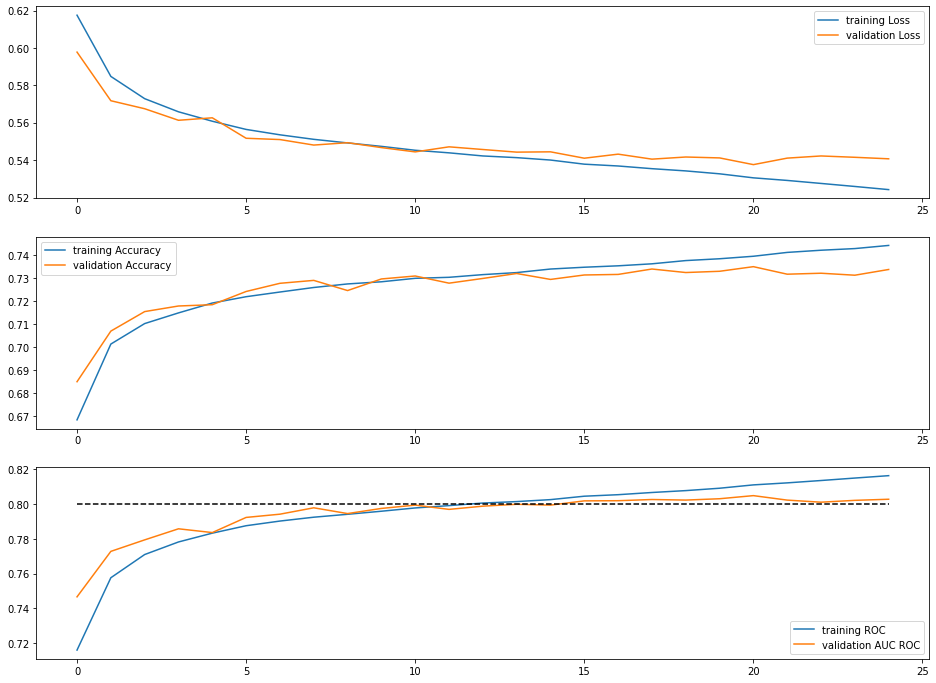

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
from torchsummary import summary

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=2),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        self.head_activation = nn.Sigmoid()

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return self.head_activation(x)

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_ft = ConvNeXt(in_chans=2, num_classes=1, depths=[2,2,6,2], dims=[32, 64, 64, 96])
model_ft = model_ft.to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              64
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 31, 31]           4,096
       BatchNorm2d-5           [-1, 32, 31, 31]              64
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 48, 30, 30]           6,144
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
        MaxPool2d-10           [-1, 48, 15, 15]               0
           Conv2d-11           [-1, 48, 13, 13]          20,736
      BatchNorm2d-12           [-1, 48, 13, 13]              96
             ReLU-13           [-1, 48, 13, 13]               0
           Conv2d-14             [-1, 6

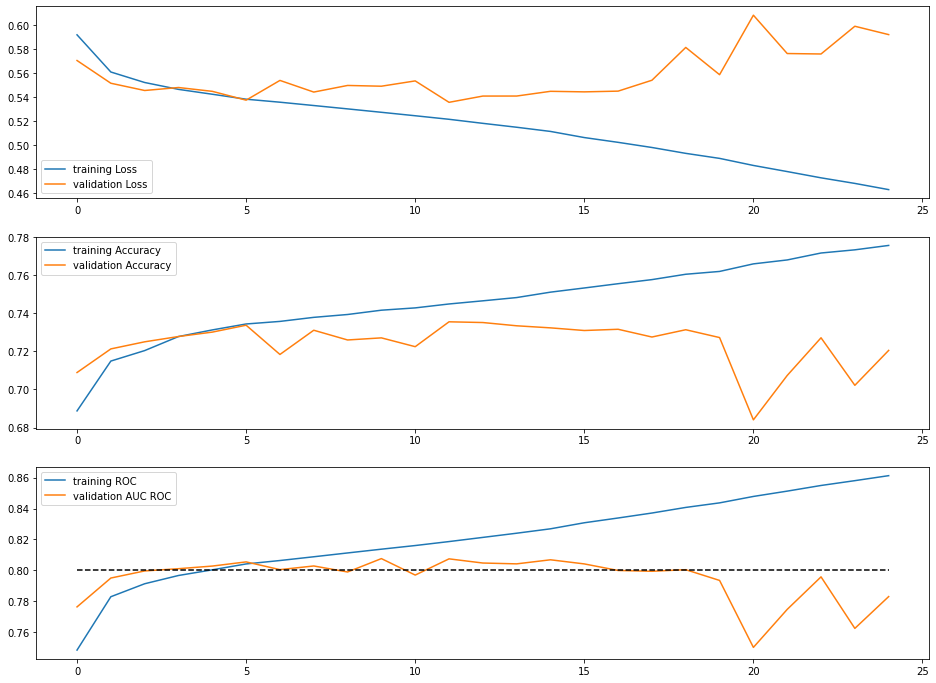

In [ ]:
class ModelV6(nn.Module):
    def __init__(self):
        super(ModelV6, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(1024, 64, bias=False)
        self.activation8 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv3 = self.pool1(conv3)
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv5 = self.pool2(conv5)

        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        ret = self.activation8(self.fc1(flat1))
        logits = self.fc2(ret)
        return self.sigmoid(logits)

model_ft = ModelV6()
model_ft = model_ft.to(device)
print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))
plotResults(res)

# Ensemble

## Sampling with replacement

In [ ]:
class smallModelForEnsemble(nn.Module):
    def __init__(self):
        super(smallModelForEnsemble, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 1, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, 2, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(32)
        self.activation2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 48, 2, bias=False)      # output becomes 24x24
        self.conv3_bn = nn.BatchNorm2d(48)
        self.activation3 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(48, 48, 3, bias=False)      # output becomes 22x22
        self.conv4_bn = nn.BatchNorm2d(48)
        self.activation4 = nn.ReLU()

        self.conv5 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.activation5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(1024, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.activation1(self.conv1_bn(self.conv1(x)))
        conv2 = self.activation2(self.conv2_bn(self.conv2(conv1)))
        conv3 = self.activation3(self.conv3_bn(self.conv3(conv2)))
        conv3 = self.pool1(conv3)
        conv4 = self.activation4(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.activation5(self.conv5_bn(self.conv5(conv4)))
        conv5 = self.pool2(conv5)

        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

In [ ]:
import random 

class PhotonElectronDatasetWithReplacement(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            val_idx = random.randint(0, len(self.photon_indexes)-1)
            image = photonX[self.photon_indexes[val_idx], :, :, :]
            label = photonY[self.photon_indexes[val_idx]]
        # electron if odd
        else:
            val_idx = random.randint(0, len(self.electron_indexes)-1)
            image = electronX[self.electron_indexes[val_idx], :, :, :]
            label = electronY[self.electron_indexes[val_idx]]

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
training_dataset_ensemble    = PhotonElectronDatasetWithReplacement(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset_ensemble  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))
testing_dataset_ensemble     = PhotonElectronDataset(electron_test_idxs, photon_test_idxs, transform=transforms.Compose([transforms.ToTensor()]))

training_ds_ensemble_size = len(training_dataset_ensemble)
validation_ensemble_ds_size = len(validation_dataset_ensemble)
testing_ds_ensemble_size = len(testing_dataset_ensemble)

print(f"training size : {training_ds_ensemble_size}")
print(f"validation size : {validation_ensemble_ds_size}")
print(f"testing size : {testing_ds_ensemble_size}")

train_dataloader_ensemble      = DataLoader(training_dataset_ensemble, batch_size=batch_size, shuffle=False)
validation_dataloader_ensemble = DataLoader(validation_dataset_ensemble, batch_size=batch_size, shuffle=False)
test_dataloader_ensemble       = DataLoader(testing_dataset_ensemble, batch_size=batch_size, shuffle=False)


training size : 398400
validation size : 49800
testing size : 49800


In [ ]:
n_models = 9
epochs_per_model = 5
models = []

dataloaders = {
      "train" : train_dataloader_ensemble,
      "val" : validation_dataloader_ensemble
  }

dataset_sizes = {
      "train" : training_ds_ensemble_size,
      "val" : validation_ensemble_ds_size
  }


for i in range(n_models):
  print("="*64)
  print(f"ENSEMBLE MODEL {i}")
  print("="*64)
  model = smallModelForEnsemble().to(device)
  optim = pt_optim.Adam(model.parameters(), 1e-3)
  lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
  res = train_model(model, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, f"ensemble{i}.pth"), num_epochs=epochs_per_model)
  models.append(model)

ENSEMBLE MODEL 0
Epoch 0/4
----------
train Loss: 0.5937 Acc: 0.6895 AUC ROC : 0.7472 Time taken : 56.36
val Loss: 0.6388 Acc: 0.6209 AUC ROC : 0.7612 Time taken : 2.96

Epoch 1/4
----------
train Loss: 0.5606 Acc: 0.7179 AUC ROC : 0.7832 Time taken : 56.41
val Loss: 0.5633 Acc: 0.7158 AUC ROC : 0.7876 Time taken : 2.94

Epoch 2/4
----------
train Loss: 0.5504 Acc: 0.7255 AUC ROC : 0.7931 Time taken : 55.67
val Loss: 0.6026 Acc: 0.7067 AUC ROC : 0.7868 Time taken : 3.07

Epoch 3/4
----------
train Loss: 0.5440 Acc: 0.7315 AUC ROC : 0.7991 Time taken : 57.05
val Loss: 0.5499 Acc: 0.7280 AUC ROC : 0.7947 Time taken : 3.39

Epoch 4/4
----------
train Loss: 0.5401 Acc: 0.7342 AUC ROC : 0.8025 Time taken : 57.18
val Loss: 0.5716 Acc: 0.7016 AUC ROC : 0.7883 Time taken : 2.89

Training complete in 4m 58s
Best val Acc: 0.728032
ENSEMBLE MODEL 1
Epoch 0/4
----------
train Loss: 0.5909 Acc: 0.6912 AUC ROC : 0.7507 Time taken : 56.56
val Loss: 0.5655 Acc: 0.7179 AUC ROC : 0.7826 Time taken : 3.5

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

class EnsembleModel(nn.Module):
    def __init__(self, models,policy="mean"):
        super(EnsembleModel, self).__init__()
        self.models = models
        #self.activtion = nn.Sigmoid()
        self.policy = policy

    def set_averaging_policy(self, policy):
      self.policy = policy
    
    def forward(self, x):
        predictions = []

        for i in range(0, len(self.models)):
          predictions.append(self.models[i](x))

        predictions = torch.cat(predictions, dim=1)

        if self.policy == "mean":
          predictions = torch.mean(predictions, dim=1)
        if self.policy == "harmonic_mean":
          predictions = predictions.shape[1] / ( torch.sum(1 / predictions, dim=1))

        return predictions.reshape(-1, 1)

ensemble = EnsembleModel(models=models, policy="mean").to(device) 
print(f"number of models : {len(ensemble.models)}")

evaluate_model(ensemble, F.binary_cross_entropy, validation_dataloader, validation_ds_size)

Device Used : cuda:0
number of models : 9
Evaluation completed in 0m 12s
Loss: 0.5376 Acc: 0.7368 AUC ROC : 0.8063 Time taken : 12.19


## Separate datasets

In [ ]:
n_models = 5
epochs_per_model = 10

electron_training_idxs_ens = electron_training_idxs
photon_training_idxs_ens = photon_training_idxs

examples_per_en_model = int(len(electron_training_idxs) / n_models)
print(f"exmaples per ensembled model : {examples_per_en_model}")

models_ens_2 = []

for i in range(n_models):
  start = i * examples_per_en_model
  end   = (i + 1) * examples_per_en_model 
  print("-" * 64)
  print(f"Ensemble Model {i}")
  print(f"{start} : {end}")
  tr_dataset_ens   = PhotonElectronDataset(electron_training_idxs[start:end], photon_training_idxs[start:end], transform=transforms.Compose([transforms.ToTensor()]))
  train_dataloader      = DataLoader(tr_dataset_ens, batch_size=batch_size, shuffle=True)
  dataloaders = {
      "train" : train_dataloader,
      "val" : validation_dataloader
      }

  dataset_sizes = {
      "train" : 2 * examples_per_en_model,
      "val" : validation_ensemble_ds_size
  }

  model = smallModelForEnsemble().to(device)
  optim = pt_optim.Adam(model.parameters(), 1e-3)
  lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
  res = train_model(model, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, f"ensemble{i}_2.pth"), num_epochs=epochs_per_model)
  models_ens_2.append(model)

exmaples per ensembled model : 39840
----------------------------------------------------------------
Ensemble Model 0
0 : 39840
Epoch 0/9
----------
train Loss: 0.6433 Acc: 0.6344 AUC ROC : 0.6791 Time taken : 10.95
val Loss: 0.6106 Acc: 0.6812 AUC ROC : 0.7351 Time taken : 2.92

Epoch 1/9
----------
train Loss: 0.6012 Acc: 0.6839 AUC ROC : 0.7389 Time taken : 10.88
val Loss: 0.5955 Acc: 0.6894 AUC ROC : 0.7528 Time taken : 2.91

Epoch 2/9
----------
train Loss: 0.5877 Acc: 0.6969 AUC ROC : 0.7547 Time taken : 10.7
val Loss: 0.5746 Acc: 0.7091 AUC ROC : 0.7689 Time taken : 2.91

Epoch 3/9
----------
train Loss: 0.5784 Acc: 0.7061 AUC ROC : 0.7651 Time taken : 10.66
val Loss: 0.6097 Acc: 0.6953 AUC ROC : 0.7641 Time taken : 3.1

Epoch 4/9
----------
train Loss: 0.5705 Acc: 0.7111 AUC ROC : 0.7733 Time taken : 10.64
val Loss: 0.5668 Acc: 0.7145 AUC ROC : 0.7777 Time taken : 3.12

Epoch 5/9
----------
train Loss: 0.5640 Acc: 0.7163 AUC ROC : 0.7800 Time taken : 10.65
val Loss: 0.5770 Acc

In [ ]:
ensemble = EnsembleModel(models=models_ens_2, policy="harmonic_mean").to(device) 
print(f"number of models : {len(ensemble.models)}")
evaluate_model(ensemble, F.binary_cross_entropy, validation_dataloader, validation_ds_size)

number of models : 5
Evaluation completed in 0m 7s
Loss: 0.5544 Acc: 0.7233 AUC ROC : 0.7906 Time taken : 7.14


# ConvMixer

### Architecture

In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    return nn.Sequential(
      nn.Conv2d(2, dim, kernel_size=patch_size, stride=patch_size),
      nn.GELU(),
      nn.BatchNorm2d(dim),
      *[nn.Sequential(
      Residual(nn.Sequential(
      nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
      nn.GELU(),
      nn.BatchNorm2d(dim)
      )),
      nn.Conv2d(dim, dim, kernel_size=1),
      nn.GELU(),
      nn.BatchNorm2d(dim)
      ) for i in range(depth)],
      nn.AdaptiveAvgPool2d((1,1)),
      nn.Flatten(),
      nn.Linear(dim, n_classes),
      nn.Sigmoid())

### Experiments

### Experiment 2
patch_size = 16

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 2, 2]          32,832
              GELU-2             [-1, 64, 2, 2]               0
       BatchNorm2d-3             [-1, 64, 2, 2]             128
            Conv2d-4             [-1, 64, 2, 2]             640
              GELU-5             [-1, 64, 2, 2]               0
       BatchNorm2d-6             [-1, 64, 2, 2]             128
          Residual-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]           4,160
              GELU-9             [-1, 64, 2, 2]               0
      BatchNorm2d-10             [-1, 64, 2, 2]             128
           Conv2d-11             [-1, 64, 2, 2]             640
             GELU-12             [-1, 64, 2, 2]               0
      BatchNorm2d-13             [-1, 64, 2, 2]             128
         Residual-14             [-1, 6

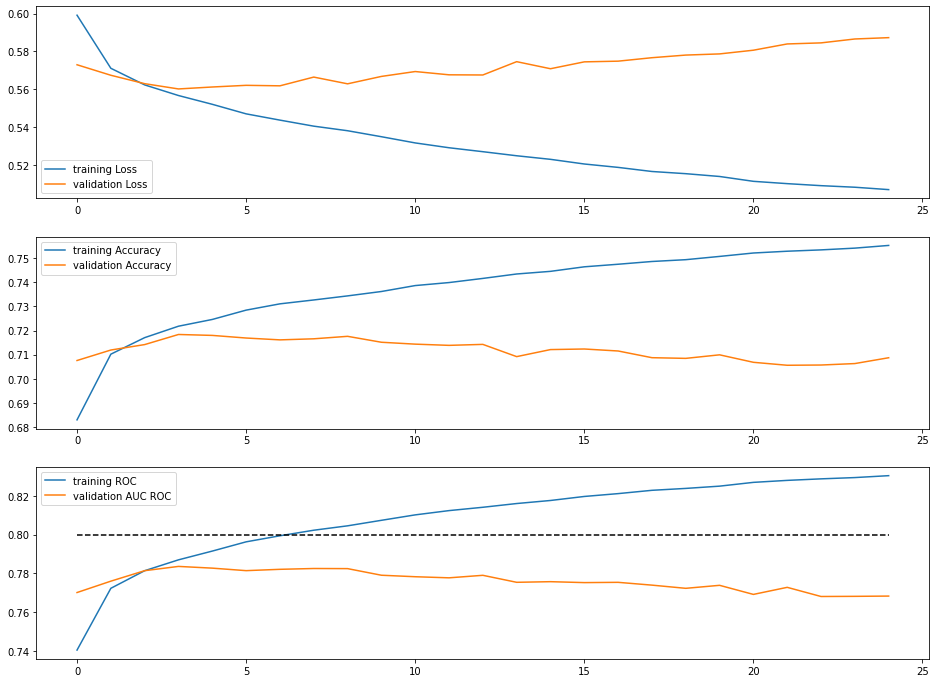

In [ ]:
model_ft = ConvMixer(64, 3,  kernel_size=3, patch_size=16, n_classes=1)
model_ft = model_ft.to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

### Experiment 2
patch_size = 8

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           8,256
              GELU-2             [-1, 64, 4, 4]               0
       BatchNorm2d-3             [-1, 64, 4, 4]             128
            Conv2d-4             [-1, 64, 4, 4]             640
              GELU-5             [-1, 64, 4, 4]               0
       BatchNorm2d-6             [-1, 64, 4, 4]             128
          Residual-7             [-1, 64, 4, 4]               0
            Conv2d-8             [-1, 64, 4, 4]           4,160
              GELU-9             [-1, 64, 4, 4]               0
      BatchNorm2d-10             [-1, 64, 4, 4]             128
           Conv2d-11             [-1, 64, 4, 4]             640
             GELU-12             [-1, 64, 4, 4]               0
      BatchNorm2d-13             [-1, 64, 4, 4]             128
         Residual-14             [-1, 6

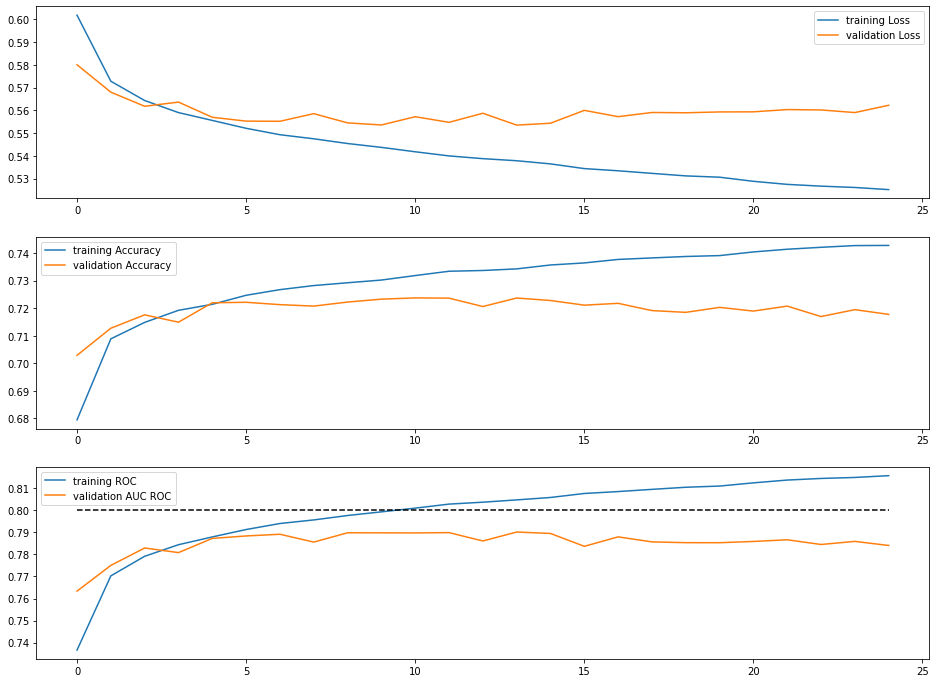

In [ ]:
model_ft = ConvMixer(64, 3,  kernel_size=3, patch_size=8, n_classes=1)
model_ft = model_ft.to(device)

print(summary(model_ft, (2,32,32)))

optim = pt_optim.Adam(model_ft.parameters(), 1e-3)
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "EnsembleModel.pth"))
plotResults(res)

### Experiment 2
- patch_size = 8
- kernels = 256

# Vision Transformer

In [ ]:
class TransformerWrapperSigmoid(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = model
    self.sigm = nn.Sigmoid()
  
  def forward(self, x):
    return self.sigm(self.model(x))

## Simple ViT

### Model

In [11]:
# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t,t)

def posemb_sincos_2d(patches, temperature=10000, dtype=torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'

    omega = torch.arange(dim // 4, device=device) / (dim // 4 - 1)
    omega = 1. / (temperature**omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)


# Classes
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, 3 * inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3,  dim_head = 64, out_sigmoid=True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.ModuleList([])

        if out_sigmoid:
            self.linear_head = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes),
                nn.Sigmoid()
            )
        else:
            self.linear_head = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, num_classes)
            )


    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        x = x.mean(dim=1)

        x = self.to_latent(x)
        return self.linear_head(x)



### Experiments

#### 1
- patch_size = 2
- dim = 128
- depth = 4
- heads = 8
- mlp_dim = 128

In [ ]:
model_ft = SimpleViT(image_size=32, patch_size=2, num_classes=1, dim=128, 
                     depth=4, heads=8, mlp_dim=128, channels=2,out_sigmoid=True)
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1            [-1, 16, 16, 8]               0
            Linear-2          [-1, 16, 16, 128]           1,152
         LayerNorm-3             [-1, 256, 128]             256
            Linear-4            [-1, 256, 1536]         196,608
           Softmax-5          [-1, 8, 256, 256]               0
            Linear-6             [-1, 256, 128]          65,536
         Attention-7             [-1, 256, 128]               0
         LayerNorm-8             [-1, 256, 128]             256
            Linear-9             [-1, 256, 128]          16,512
             GELU-10             [-1, 256, 128]               0
           Linear-11             [-1, 256, 128]          16,512
      FeedForward-12             [-1, 256, 128]               0
        LayerNorm-13             [-1, 256, 128]             256
           Linear-14            [-1, 25

KeyboardInterrupt: ignored

#### 2
- patch_size = 4
- dim = 128
- depth = 4
- heads = 8
- mlp_dim = 128


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 8, 8, 32]               0
            Linear-2            [-1, 8, 8, 128]           4,224
         LayerNorm-3              [-1, 64, 128]             256
            Linear-4             [-1, 64, 1536]         196,608
           Softmax-5            [-1, 8, 64, 64]               0
            Linear-6              [-1, 64, 128]          65,536
         Attention-7              [-1, 64, 128]               0
         LayerNorm-8              [-1, 64, 128]             256
            Linear-9              [-1, 64, 128]          16,512
             GELU-10              [-1, 64, 128]               0
           Linear-11              [-1, 64, 128]          16,512
      FeedForward-12              [-1, 64, 128]               0
        LayerNorm-13              [-1, 64, 128]             256
           Linear-14             [-1, 6

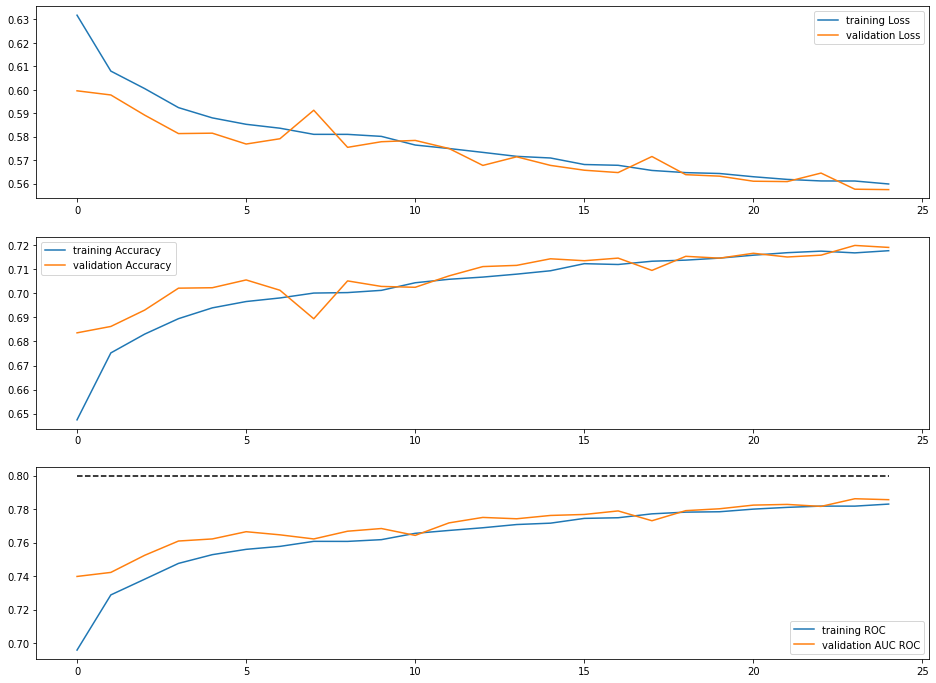

In [ ]:
model_ft = SimpleViT(image_size=32, patch_size=4, num_classes=1, dim=128, 
                     depth=4, heads=8, mlp_dim=128, channels=2,out_sigmoid=True)
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

#### 3
- patch_size = 8
- dim = 128
- depth = 4
- heads = 8
- mlp_dim = 128

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1            [-1, 4, 4, 128]               0
            Linear-2            [-1, 4, 4, 128]          16,512
         LayerNorm-3              [-1, 16, 128]             256
            Linear-4             [-1, 16, 1536]         196,608
           Softmax-5            [-1, 8, 16, 16]               0
            Linear-6              [-1, 16, 128]          65,536
         Attention-7              [-1, 16, 128]               0
         LayerNorm-8              [-1, 16, 128]             256
            Linear-9              [-1, 16, 128]          16,512
             GELU-10              [-1, 16, 128]               0
           Linear-11              [-1, 16, 128]          16,512
      FeedForward-12              [-1, 16, 128]               0
        LayerNorm-13              [-1, 16, 128]             256
           Linear-14             [-1, 1

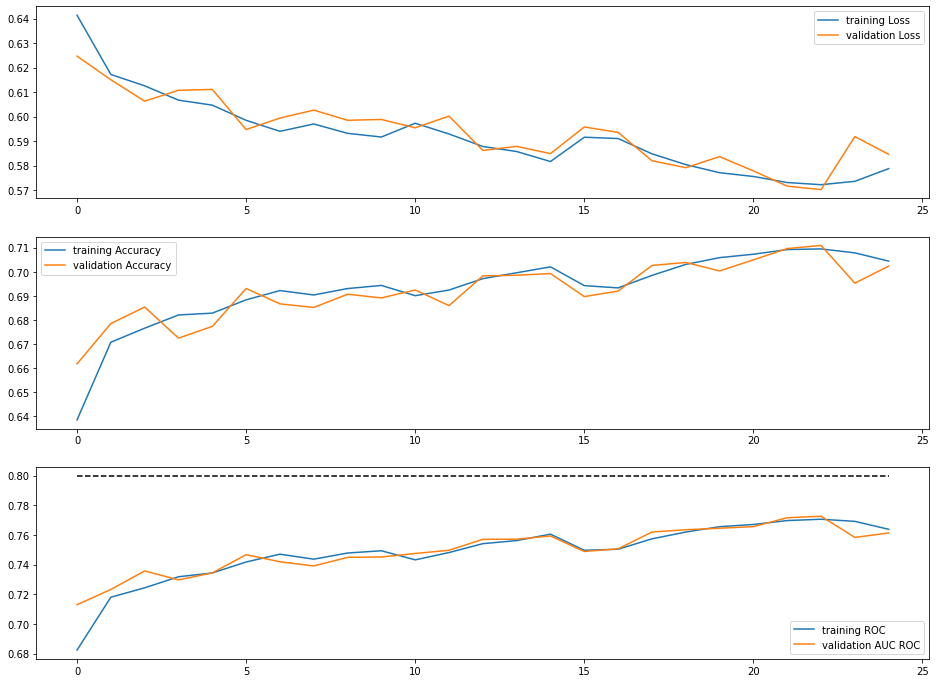

In [ ]:
model_ft = SimpleViT(image_size=32, patch_size=8, num_classes=1, dim=128, 
                     depth=4, heads=8, mlp_dim=128, channels=2,out_sigmoid=True)
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

#### 4
- patch_size = 16
- dim = 128
- depth = 4
- heads = 8
- mlp_dim = 128

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1            [-1, 2, 2, 512]               0
            Linear-2            [-1, 2, 2, 128]          65,664
         LayerNorm-3               [-1, 4, 128]             256
            Linear-4              [-1, 4, 1536]         196,608
           Softmax-5              [-1, 8, 4, 4]               0
            Linear-6               [-1, 4, 128]          65,536
         Attention-7               [-1, 4, 128]               0
         LayerNorm-8               [-1, 4, 128]             256
            Linear-9               [-1, 4, 128]          16,512
             GELU-10               [-1, 4, 128]               0
           Linear-11               [-1, 4, 128]          16,512
      FeedForward-12               [-1, 4, 128]               0
        LayerNorm-13               [-1, 4, 128]             256
           Linear-14              [-1, 

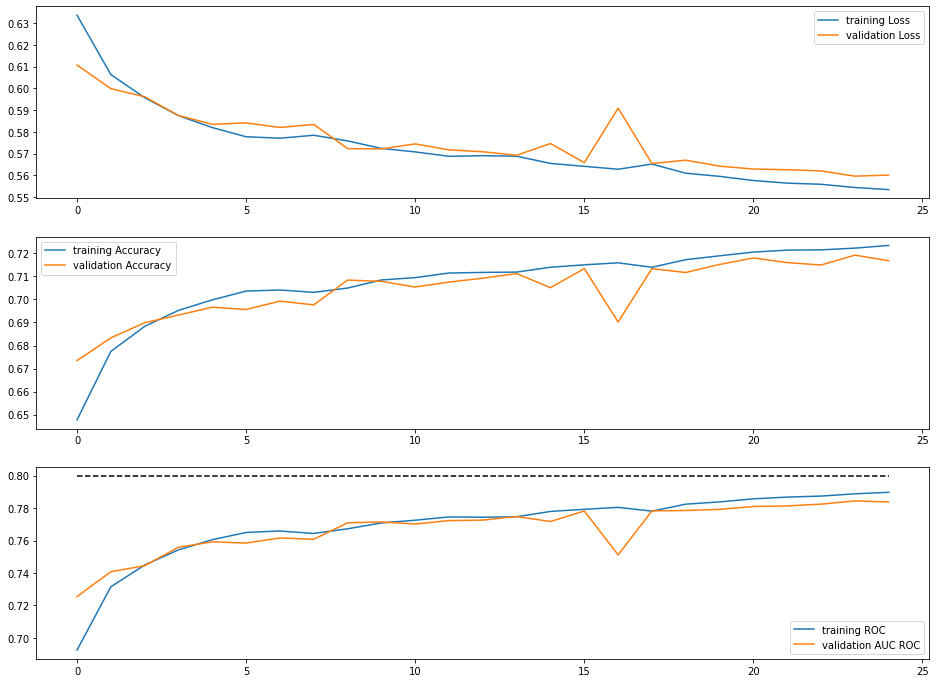

In [ ]:
model_ft = SimpleViT(image_size=32, patch_size=16, num_classes=1, dim=128, 
                     depth=4, heads=8, mlp_dim=128, channels=2,out_sigmoid=True)
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

## Mobile ViT

### Architecture 

In [13]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Reduce

# helpers

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    """Transformer block described in ViT.
    Paper: https://arxiv.org/abs/2010.11929
    Based on: https://github.com/lucidrains/vit-pytorch
    """

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MV2Block(nn.Module):
    """MV2 block described in MobileNetV2.
    Paper: https://arxiv.org/pdf/1801.04381
    Based on: https://github.com/tonylins/pytorch-mobilenet-v2
    """

    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d',
                      ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)',
                      h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x

class MobileViT2(nn.Module):
    """MobileViT.
    Paper: https://arxiv.org/abs/2110.02178
    Based on: https://github.com/chinhsuanwu/mobilevit-pytorch
    """

    def __init__(
        self,
        image_size,
        dims,
        channels,
        num_classes,
        expansion=4,
        kernel_size=3,
        patch_size=(2, 2),
        depths=(2, 4, 3)
    ):
        super().__init__()
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'

        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        init_dim, *_, last_dim = channels

        self.conv1 = conv_nxn_bn(2, init_dim, stride=2)

        self.stem = nn.ModuleList([])
        self.stem.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.stem.append(MV2Block(channels[1], channels[2], 2, expansion))


        self.trunk = nn.ModuleList([])
        self.trunk.append(nn.ModuleList([
            MV2Block(channels[2], channels[3], 2, expansion),
            MobileViTBlock(dims[0], depths[0], channels[len(channels)-1],
                           kernel_size, patch_size, int(dims[0] * 2))
        ]))

        self.head = nn.Sequential(
            conv_1x1_bn(channels[-2], last_dim),
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(channels[-1], num_classes, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)

        for conv in self.stem:
            x = conv(x)

        for conv, attn in self.trunk:
            x = conv(x)
            x = attn(x)

        return self.head(x)


### Experiment

#### Experiment 1
starting point ( default parameters)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             288
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              SiLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           1,024
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              SiLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]             576
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              SiLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,048
      BatchNorm2d-11           [-1, 32, 16, 16]              64
         MV2Block-12           [-1, 32, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           4,096
      BatchNorm2d-14          [-1, 128,

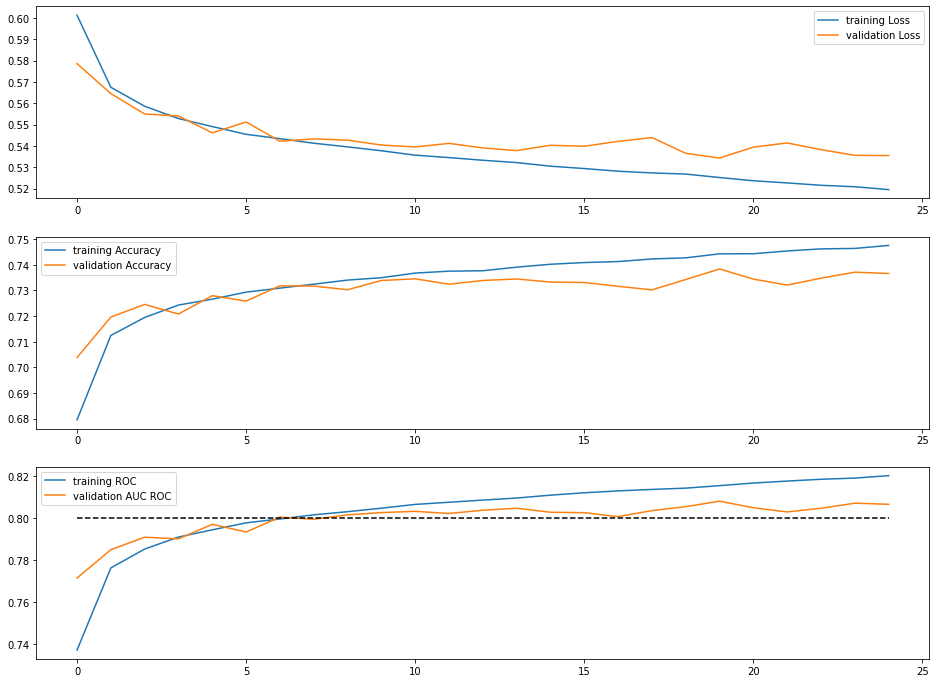

In [ ]:
model_ft = MobileViT2(image_size = (32, 32),
                        dims = [32, 48, 64],
                        channels = [16, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(2, 2),
                        kernel_size=3,
                        depths=(2, 4, 3))
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             288
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              SiLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           1,024
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              SiLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]             576
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              SiLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,048
      BatchNorm2d-11           [-1, 32, 16, 16]              64
         MV2Block-12           [-1, 32, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           4,096
      BatchNorm2d-14          [-1, 128,

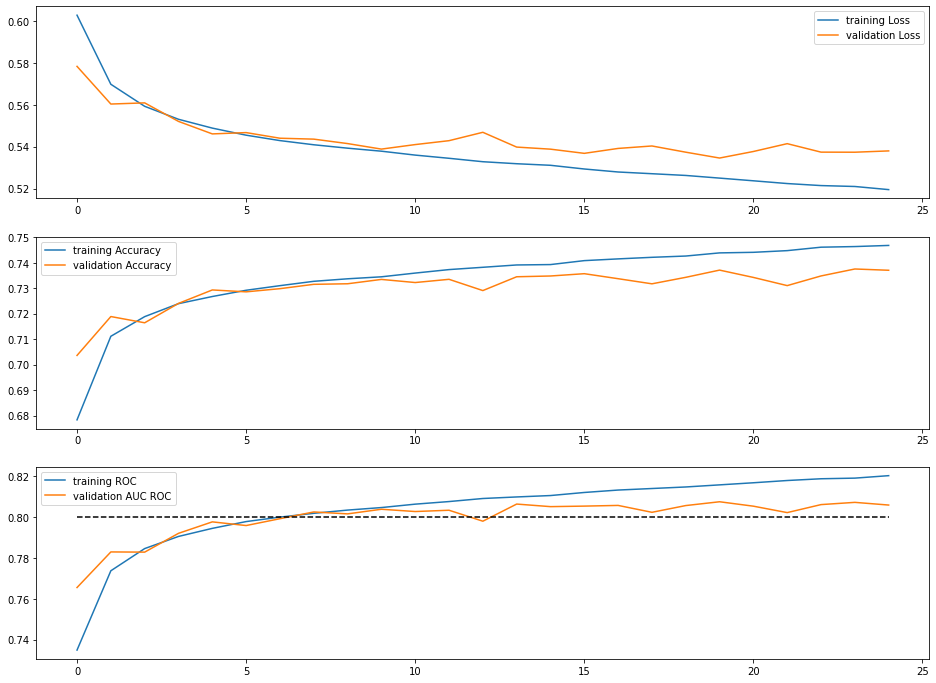

In [ ]:
model_ft = MobileViT2(image_size = (32, 32),
                        dims = [32, 48, 64],
                        channels = [16, 32, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(4, 4),
                        kernel_size=3,
                        depths=(2, 4, 3))
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             576
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]           4,096
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              SiLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]           1,152
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              SiLU-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 48, 16, 16]           6,144
      BatchNorm2d-11           [-1, 48, 16, 16]              96
         MV2Block-12           [-1, 48, 16, 16]               0
           Conv2d-13          [-1, 192, 16, 16]           9,216
      BatchNorm2d-14          [-1, 192,

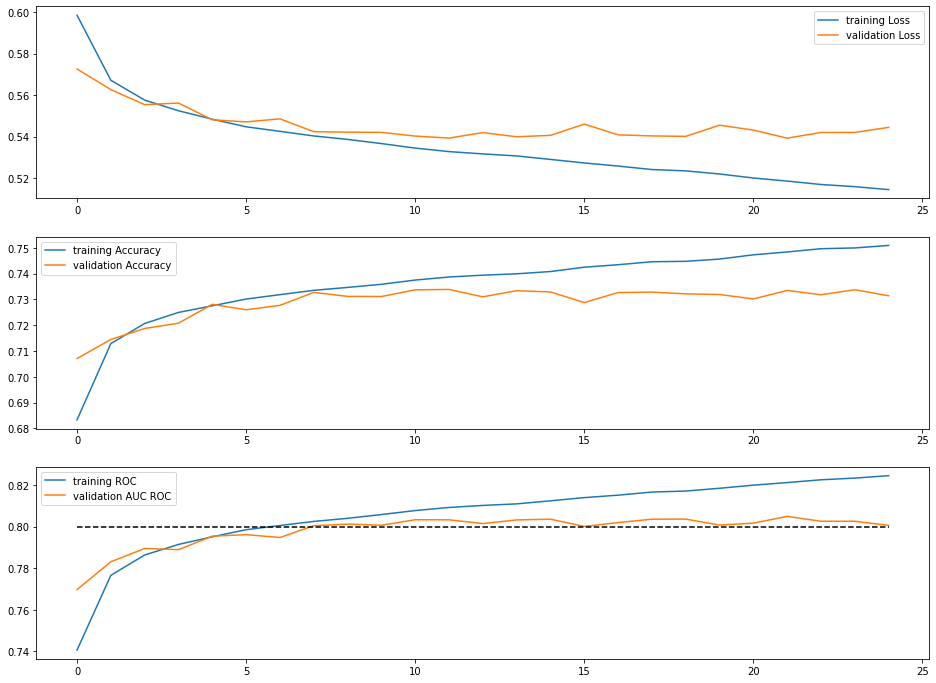

In [ ]:
model_ft = MobileViT2(image_size = (32, 32),
                        dims = [32, 48, 64],
                        channels = [32, 48, 48, 96, 96],
                        num_classes = 1,
                        patch_size=(4,4),
                        kernel_size=3,
                        depths=(2, 2, 2))
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

#### Experiment 5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             576
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]           4,096
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              SiLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]           1,152
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              SiLU-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 48, 16, 16]           6,144
      BatchNorm2d-11           [-1, 48, 16, 16]              96
         MV2Block-12           [-1, 48, 16, 16]               0
           Conv2d-13          [-1, 192, 16, 16]           9,216
      BatchNorm2d-14          [-1, 192,

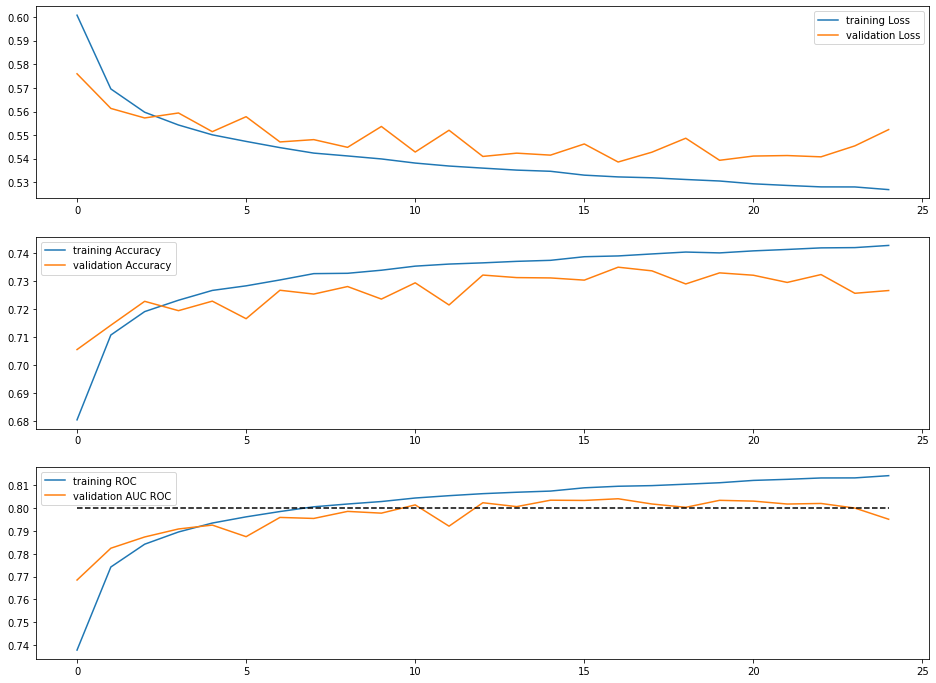

In [23]:
model_ft = MobileViT2(image_size = (32, 32),
                        dims = [64, 96, 128],
                        channels = [32, 48, 64, 128, 128],
                        num_classes = 1,
                        patch_size=(4, 4),
                        kernel_size=3,
                        depths=(1, 2, 1))
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32, 32)))

optim = pt_optim.AdamW(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

## Swin Transformer

### Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
        pretrained_window_size (tuple[int]): The height and width of the window in pre-training.
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.,
                 pretrained_window_size=[0, 0]):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.pretrained_window_size = pretrained_window_size
        self.num_heads = num_heads

        self.logit_scale = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(nn.Linear(2, 512, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(512, num_heads, bias=False))

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = torch.stack(
            torch.meshgrid([relative_coords_h,
                            relative_coords_w])).permute(1, 2, 0).contiguous().unsqueeze(0)  # 1, 2*Wh-1, 2*Ww-1, 2
        if pretrained_window_size[0] > 0:
            relative_coords_table[:, :, :, 0] /= (pretrained_window_size[0] - 1)
            relative_coords_table[:, :, :, 1] /= (pretrained_window_size[1] - 1)
        else:
            relative_coords_table[:, :, :, 0] /= (self.window_size[0] - 1)
            relative_coords_table[:, :, :, 1] /= (self.window_size[1] - 1)
        relative_coords_table *= 8  # normalize to -8, 8
        relative_coords_table = torch.sign(relative_coords_table) * torch.log2(
            torch.abs(relative_coords_table) + 1.0) / np.log2(8)

        self.register_buffer("relative_coords_table", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(dim))
            self.v_bias = nn.Parameter(torch.zeros(dim))
        else:
            self.q_bias = None
            self.v_bias = None
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # cosine attention
        attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
        logit_scale = torch.clamp(self.logit_scale, max=torch.log(torch.tensor(1. / 0.01)).to(device)).exp()
        attn = attn * logit_scale

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, ' \
               f'pretrained_window_size={self.pretrained_window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        pretrained_window_size (int): Window size in pre-training.
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, pretrained_window_size=0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop,
            pretrained_window_size=to_2tuple(pretrained_window_size))

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(self.norm1(x))

        # FFN
        x = x + self.drop_path(self.norm2(self.mlp(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(2 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.reduction(x)
        x = self.norm(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        flops += H * W * self.dim // 2
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        pretrained_window_size (int): Local window size in pre-training.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 pretrained_window_size=0):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,
                                 pretrained_window_size=pretrained_window_size)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

    def _init_respostnorm(self):
        for blk in self.blocks:
            nn.init.constant_(blk.norm1.bias, 0)
            nn.init.constant_(blk.norm1.weight, 0)
            nn.init.constant_(blk.norm2.bias, 0)
            nn.init.constant_(blk.norm2.weight, 0)


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformerV2(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        pretrained_window_sizes (tuple(int)): Pretrained window sizes of each layer.
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, pretrained_window_sizes=[0, 0, 0, 0], **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint,
                               pretrained_window_size=pretrained_window_sizes[i_layer])
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)
        for bly in self.layers:
            bly._init_respostnorm()

        self.head_activ = nn.Sigmoid()

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {"cpb_mlp", "logit_scale", 'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return self.head_activ(x)

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops


### Experiments

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           3,168
         LayerNorm-2               [-1, 64, 96]             192
        PatchEmbed-3               [-1, 64, 96]               0
           Dropout-4               [-1, 64, 96]               0
            Linear-5          [-1, 15, 15, 512]           1,536
              ReLU-6          [-1, 15, 15, 512]               0
            Linear-7            [-1, 15, 15, 3]           1,536
           Softmax-8            [-1, 3, 64, 64]               0
           Dropout-9            [-1, 3, 64, 64]               0
           Linear-10               [-1, 64, 96]           9,312
          Dropout-11               [-1, 64, 96]               0
  WindowAttention-12               [-1, 64, 96]               0
        LayerNorm-13               [-1, 64, 96]             192
         Identity-14               [-1,

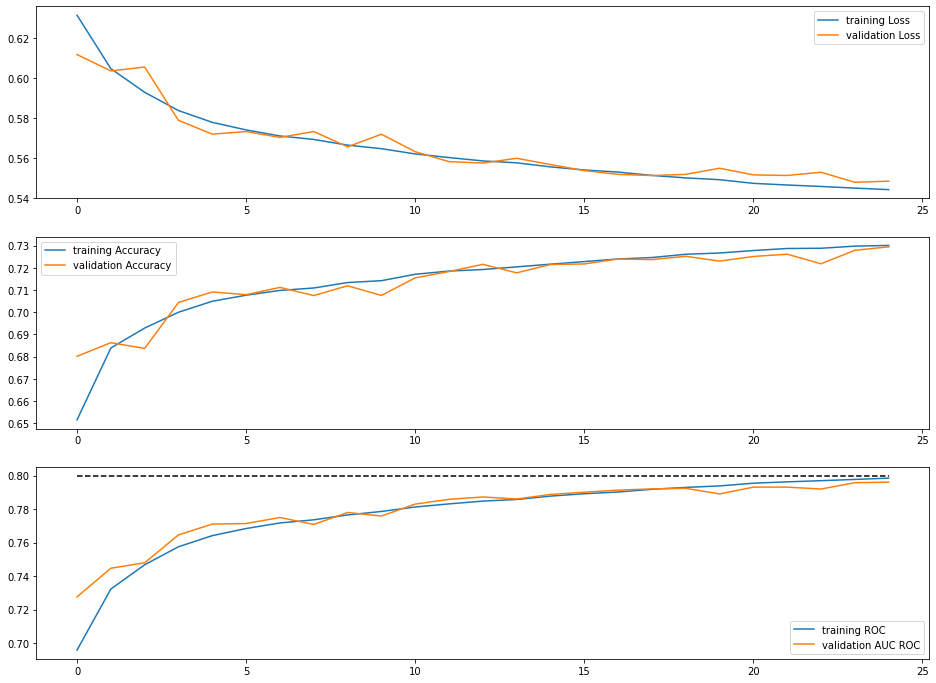

In [ ]:
model_ft = SwinTransformerV2(img_size = 32,
                             window_size=8,
                             in_chans = 2,
                             depths=[3],
                             num_heads=[3, 6, 12, 24],
                             num_classes = 1)
model_ft = model_ft.to(device)

print(summary(model_ft, (2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

## Focal Modulation Network

### Architecture

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import create_transform

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)     
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class FocalModulation(nn.Module):
    def __init__(self, dim, focal_window, focal_level, focal_factor=2, bias=True, proj_drop=0., use_postln_in_modulation=False, normalize_modulator=False):
        super().__init__()

        self.dim = dim
        self.focal_window = focal_window
        self.focal_level = focal_level
        self.focal_factor = focal_factor
        self.use_postln_in_modulation = use_postln_in_modulation
        self.normalize_modulator = normalize_modulator

        self.f = nn.Linear(dim, 2*dim + (self.focal_level+1), bias=bias)
        self.h = nn.Conv2d(dim, dim, kernel_size=1, stride=1, bias=bias)

        self.act = nn.GELU()
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.focal_layers = nn.ModuleList()
                
        self.kernel_sizes = []
        for k in range(self.focal_level):
            kernel_size = self.focal_factor*k + self.focal_window
            self.focal_layers.append(
                nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size=kernel_size, stride=1, 
                    groups=dim, padding=kernel_size//2, bias=False),
                    nn.GELU(),
                    )
                )              
            self.kernel_sizes.append(kernel_size)          
        if self.use_postln_in_modulation:
            self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        """
        Args:
            x: input features with shape of (B, H, W, C)
        """
        C = x.shape[-1]

        # pre linear projection
        x = self.f(x).permute(0, 3, 1, 2).contiguous()
        q, ctx, self.gates = torch.split(x, (C, C, self.focal_level+1), 1)
        
        # context aggreation
        ctx_all = 0 
        for l in range(self.focal_level):         
            ctx = self.focal_layers[l](ctx)
            ctx_all = ctx_all + ctx*self.gates[:, l:l+1]
        ctx_global = self.act(ctx.mean(2, keepdim=True).mean(3, keepdim=True))
        ctx_all = ctx_all + ctx_global*self.gates[:,self.focal_level:]

        # normalize context
        if self.normalize_modulator:
            ctx_all = ctx_all / (self.focal_level+1)

        # focal modulation
        self.modulator = self.h(ctx_all)
        x_out = q*self.modulator
        x_out = x_out.permute(0, 2, 3, 1).contiguous()
        if self.use_postln_in_modulation:
            x_out = self.ln(x_out)
        
        # post linear porjection
        x_out = self.proj(x_out)
        x_out = self.proj_drop(x_out)
        return x_out

    def extra_repr(self) -> str:
        return f'dim={self.dim}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0

        flops += N * self.dim * (self.dim * 2 + (self.focal_level+1))

        # focal convolution
        for k in range(self.focal_level):
            flops += N * (self.kernel_sizes[k]**2+1) * self.dim

        # global gating
        flops += N * 1 * self.dim 

        #  self.linear
        flops += N * self.dim * (self.dim + 1)

        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

class FocalNetBlock(nn.Module):
    r""" Focal Modulation Network Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        focal_level (int): Number of focal levels. 
        focal_window (int): Focal window size at first focal level
        use_layerscale (bool): Whether use layerscale
        layerscale_value (float): Initial layerscale value
        use_postln (bool): Whether use layernorm after modulation
    """

    def __init__(self, dim, input_resolution, mlp_ratio=4., drop=0., drop_path=0., 
                    act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                    focal_level=1, focal_window=3,
                    use_layerscale=False, layerscale_value=1e-4, 
                    use_postln=False, use_postln_in_modulation=False, 
                    normalize_modulator=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.mlp_ratio = mlp_ratio

        self.focal_window = focal_window
        self.focal_level = focal_level
        self.use_postln = use_postln

        self.norm1 = norm_layer(dim)
        self.modulation = FocalModulation(
            dim, proj_drop=drop, focal_window=focal_window, focal_level=self.focal_level, 
            use_postln_in_modulation=use_postln_in_modulation, normalize_modulator=normalize_modulator
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.gamma_1 = 1.0
        self.gamma_2 = 1.0    
        if use_layerscale:
            self.gamma_1 = nn.Parameter(layerscale_value * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(layerscale_value * torch.ones((dim)), requires_grad=True)

        self.H = None
        self.W = None

    def forward(self, x):
        H, W = self.H, self.W
        B, L, C = x.shape
        shortcut = x

        # Focal Modulation
        x = x if self.use_postln else self.norm1(x)
        x = x.view(B, H, W, C)
        x = self.modulation(x).view(B, H * W, C)
        x = x if not self.use_postln else self.norm1(x)

        # FFN
        x = shortcut + self.drop_path(self.gamma_1 * x)
        x = x + self.drop_path(self.gamma_2 * (self.norm2(self.mlp(x)) if self.use_postln else self.mlp(self.norm2(x))))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, " \
               f"mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        
        # W-MSA/SW-MSA
        flops += self.modulation.flops(H*W)

        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

class BasicLayer(nn.Module):
    """ A basic Focal Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        focal_level (int): Number of focal levels
        focal_window (int): Focal window size at first focal level
        use_layerscale (bool): Whether use layerscale
        layerscale_value (float): Initial layerscale value
        use_postln (bool): Whether use layernorm after modulation
    """

    def __init__(self, dim, out_dim, input_resolution, depth,
                 mlp_ratio=4., drop=0., drop_path=0., norm_layer=nn.LayerNorm, 
                 downsample=None, use_checkpoint=False, 
                 focal_level=1, focal_window=1, 
                 use_conv_embed=False, 
                 use_layerscale=False, layerscale_value=1e-4, 
                 use_postln=False, 
                 use_postln_in_modulation=False, 
                 normalize_modulator=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        
        # build blocks
        self.blocks = nn.ModuleList([
            FocalNetBlock(
                dim=dim, 
                input_resolution=input_resolution,
                mlp_ratio=mlp_ratio, 
                drop=drop, 
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                focal_level=focal_level,
                focal_window=focal_window, 
                use_layerscale=use_layerscale, 
                layerscale_value=layerscale_value,
                use_postln=use_postln, 
                use_postln_in_modulation=use_postln_in_modulation, 
                normalize_modulator=normalize_modulator, 
            )
            for i in range(depth)])

        if downsample is not None:
            self.downsample = downsample(
                img_size=input_resolution, 
                patch_size=2, 
                in_chans=dim, 
                embed_dim=out_dim, 
                use_conv_embed=use_conv_embed, 
                norm_layer=norm_layer, 
                is_stem=False
            )
        else:
            self.downsample = None

    def forward(self, x, H, W):
        for blk in self.blocks:
            blk.H, blk.W = H, W
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        if self.downsample is not None:
            x = x.transpose(1, 2).reshape(x.shape[0], -1, H, W)
            x, Ho, Wo = self.downsample(x)
        else:
            Ho, Wo = H, W        
        return x, Ho, Wo

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=(224, 224), patch_size=4, in_chans=3, embed_dim=96, use_conv_embed=False, norm_layer=None, is_stem=False):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if use_conv_embed:
            # if we choose to use conv embedding, then we treat the stem and non-stem differently
            if is_stem:
                kernel_size = 7; padding = 2; stride = 4
            else:
                kernel_size = 3; padding = 1; stride = 2
            self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.proj(x)        
        H, W = x.shape[2:]
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x, H, W

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

class FocalNet(nn.Module):
    r""" Focal Modulation Networks (FocalNets)
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Focal Transformer layer.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        drop_rate (float): Dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False 
        focal_levels (list): How many focal levels at all stages. Note that this excludes the finest-grain level. Default: [1, 1, 1, 1] 
        focal_windows (list): The focal window size at all stages. Default: [7, 5, 3, 1] 
        use_conv_embed (bool): Whether use convolutional embedding. We noted that using convolutional embedding usually improve the performance, but we do not use it by default. Default: False 
        use_layerscale (bool): Whether use layerscale proposed in CaiT. Default: False 
        layerscale_value (float): Value for layer scale. Default: 1e-4 
        use_postln (bool): Whether use layernorm after modulation (it helps stablize training of large models)
    """
    def __init__(self, 
                img_size=224, 
                patch_size=4, 
                in_chans=3, 
                num_classes=1000,
                embed_dim=96, 
                depths=[2, 2, 6, 2], 
                mlp_ratio=4., 
                drop_rate=0., 
                drop_path_rate=0.1,
                norm_layer=nn.LayerNorm, 
                patch_norm=True,
                use_checkpoint=False,                 
                focal_levels=[2, 2, 2, 2], 
                focal_windows=[3, 3, 3, 3], 
                use_conv_embed=False, 
                use_layerscale=False, 
                layerscale_value=1e-4, 
                use_postln=False, 
                use_postln_in_modulation=False, 
                normalize_modulator=False, 
                **kwargs):
        super().__init__()

        self.num_layers = len(depths)
        embed_dim = [embed_dim * (2 ** i) for i in range(self.num_layers)]

        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.num_features = embed_dim[-1]
        self.mlp_ratio = mlp_ratio
        
        # split image into patches using either non-overlapped embedding or overlapped embedding
        self.patch_embed = PatchEmbed(
            img_size=to_2tuple(img_size), 
            patch_size=patch_size, 
            in_chans=in_chans, 
            embed_dim=embed_dim[0], 
            use_conv_embed=use_conv_embed, 
            norm_layer=norm_layer if self.patch_norm else None, 
            is_stem=True)

        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=embed_dim[i_layer], 
                               out_dim=embed_dim[i_layer+1] if (i_layer < self.num_layers - 1) else None,  
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               mlp_ratio=self.mlp_ratio,
                               drop=drop_rate, 
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer, 
                               downsample=PatchEmbed if (i_layer < self.num_layers - 1) else None,
                               focal_level=focal_levels[i_layer], 
                               focal_window=focal_windows[i_layer], 
                               use_conv_embed=use_conv_embed,
                               use_checkpoint=use_checkpoint, 
                               use_layerscale=use_layerscale, 
                               layerscale_value=layerscale_value, 
                               use_postln=use_postln,
                               use_postln_in_modulation=use_postln_in_modulation, 
                               normalize_modulator=normalize_modulator
                    )
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_activ = nn.Sigmoid()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {''}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {''}

    def forward_features(self, x):
        x, H, W = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x, H, W = layer(x, H, W)
        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return self.head_activ(x)

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops


### Experiments

Epoch 0/24
----------
train Loss: 0.6560 Acc: 0.6075 AUC ROC : 0.6532 Time taken : 187.81
val Loss: 0.6257 Acc: 0.6641 AUC ROC : 0.7143 Time taken : 8.56

Epoch 1/24
----------
train Loss: 0.6138 Acc: 0.6763 AUC ROC : 0.7213 Time taken : 186.33
val Loss: 0.6047 Acc: 0.6837 AUC ROC : 0.7344 Time taken : 8.38

Epoch 2/24
----------
train Loss: 0.5979 Acc: 0.6900 AUC ROC : 0.7419 Time taken : 186.78
val Loss: 0.5896 Acc: 0.6978 AUC ROC : 0.7560 Time taken : 8.58

Epoch 3/24
----------
train Loss: 0.5851 Acc: 0.7004 AUC ROC : 0.7569 Time taken : 185.59
val Loss: 0.5807 Acc: 0.6996 AUC ROC : 0.7618 Time taken : 8.37

Epoch 4/24
----------
train Loss: 0.5769 Acc: 0.7067 AUC ROC : 0.7658 Time taken : 185.41
val Loss: 0.5752 Acc: 0.7051 AUC ROC : 0.7683 Time taken : 8.73

Epoch 5/24
----------
train Loss: 0.5703 Acc: 0.7117 AUC ROC : 0.7726 Time taken : 183.8
val Loss: 0.5773 Acc: 0.7045 AUC ROC : 0.7733 Time taken : 8.72

Epoch 6/24
----------
train Loss: 0.5661 Acc: 0.7146 AUC ROC : 0.7772 T

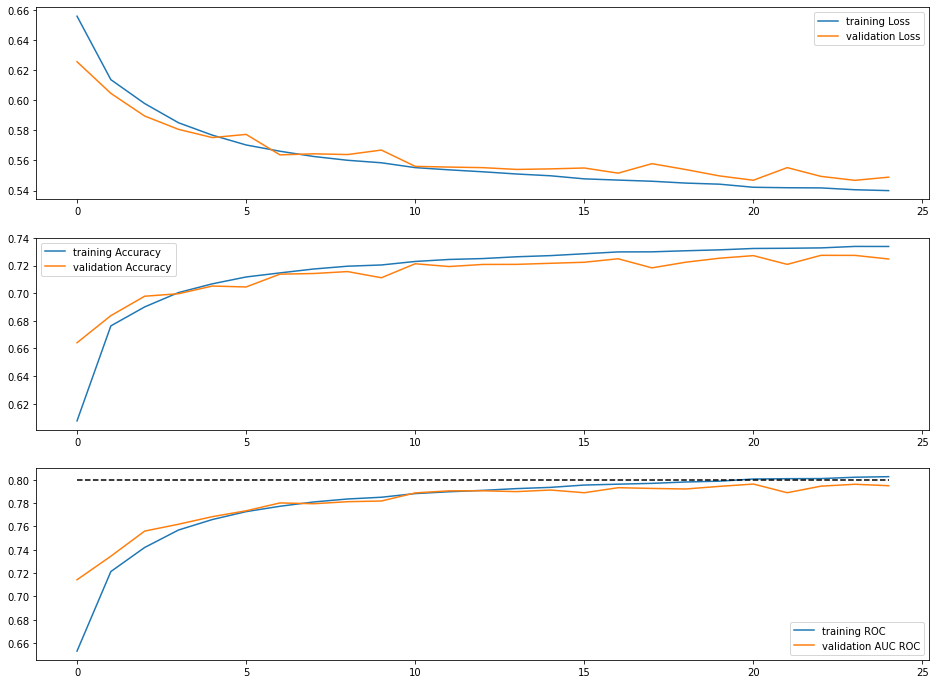

In [30]:
r""" Focal Modulation Networks (FocalNets)
class FocalNet(nn.Module):
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Focal Transformer layer.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        drop_rate (float): Dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False 
        focal_levels (list): How many focal levels at all stages. Note that this excludes the finest-grain level. Default: [1, 1, 1, 1] 
        focal_windows (list): The focal window size at all stages. Default: [7, 5, 3, 1] 
        use_conv_embed (bool): Whether use convolutional embedding. We noted that using convolutional embedding usually improve the performance, but we do not use it by default. Default: False 
        use_layerscale (bool): Whether use layerscale proposed in CaiT. Default: False 
        layerscale_value (float): Value for layer scale. Default: 1e-4 
        use_postln (bool): Whether use layernorm after modulation (it helps stablize training of large models)
    def __init__(self, 
                img_size=224, 
                patch_size=4, 
                in_chans=3, 
                num_classes=1000,
                embed_dim=96, 
                depths=[2, 2, 6, 2], 
                mlp_ratio=4., 
                drop_rate=0., 
                drop_path_rate=0.1,
                norm_layer=nn.LayerNorm, 
                patch_norm=True,
                use_checkpoint=False,                 
                focal_levels=[2, 2, 2, 2], 
                focal_windows=[3, 3, 3, 3], 
                use_conv_embed=False, 
                use_layerscale=False, 
                layerscale_value=1e-4, 
                use_postln=False, 
                use_postln_in_modulation=False, 
                normalize_modulator=False, 
                **kwargs):
    """


model_ft = FocalNet(img_size = 32,
                    patch_size = 4,
                    window_size=8,
                    in_chans = 2,
                    num_classes = 1,
                    depths=[2, 3])
model_ft = model_ft.to(device)

#print(summary(model_ft, (2, 32, 32)))

optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "simpleViT.pth"))
plotResults(simple_res)

# Graph Neural Network